In [1]:
%matplotlib inline
import numpy as np
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
import re
from datetime import datetime
from   scipy.stats import f as f_dist
import scipy.stats as stats

In [2]:
%config Completer.use_jedi = False

In [3]:
file_list = os.listdir('./YQ data for Marco')
file_list = glob('./YQ data for Marco/*.pkl')
for file in file_list:
    print(file)

animal_group_dict = {
    '49':'KV1.1',
    '213':'KV1.1',
    '205':'GFP',
    '94':'KV1.1',
    '50':'Kir2.1',
    '52':'Kir2.1',
    '211':'KV1.1',
    '104':'GFP',
    '214':'GFP',
    '99':'KV1.1',
    '44':'Kir2.1',
    '215':'GFP',
    '212':'GFP',
    '193':'KV1.1',
    '51':'KV1.1',
    '210':'GFP',
    '45':'Kir2.1',
}


get_animal= re.compile('/\d*_YQ')

file_list.sort(key = lambda f:animal_group_dict[get_animal.search(f).group()[1:-3]])

./YQ data for Marco/49_YQ_True_dex.pkl
./YQ data for Marco/213_YQ_True_dex.pkl
./YQ data for Marco/205_YQ_True_dex.pkl
./YQ data for Marco/94_YQ_True_dex.pkl
./YQ data for Marco/50_YQ_True_dex.pkl
./YQ data for Marco/52_YQ_True_dex.pkl
./YQ data for Marco/211_YQ_True_dex.pkl
./YQ data for Marco/104_YQ_True_dex.pkl
./YQ data for Marco/214_YQ_True_dex.pkl
./YQ data for Marco/99_YQ_True_dex.pkl
./YQ data for Marco/44_YQ_True_dex.pkl
./YQ data for Marco/215_YQ_True_dex.pkl
./YQ data for Marco/212_YQ_True_dex.pkl
./YQ data for Marco/193_YQ_True_dex.pkl
./YQ data for Marco/51_YQ_True_dex.pkl
./YQ data for Marco/210_YQ_True_dex.pkl
./YQ data for Marco/45_YQ_True_dex.pkl


In [4]:
for file in file_list:
    print(file,animal_group_dict[get_animal.search(file).group()[1:-3]])

./YQ data for Marco/205_YQ_True_dex.pkl GFP
./YQ data for Marco/104_YQ_True_dex.pkl GFP
./YQ data for Marco/214_YQ_True_dex.pkl GFP
./YQ data for Marco/215_YQ_True_dex.pkl GFP
./YQ data for Marco/212_YQ_True_dex.pkl GFP
./YQ data for Marco/210_YQ_True_dex.pkl GFP
./YQ data for Marco/49_YQ_True_dex.pkl KV1.1
./YQ data for Marco/213_YQ_True_dex.pkl KV1.1
./YQ data for Marco/94_YQ_True_dex.pkl KV1.1
./YQ data for Marco/211_YQ_True_dex.pkl KV1.1
./YQ data for Marco/99_YQ_True_dex.pkl KV1.1
./YQ data for Marco/193_YQ_True_dex.pkl KV1.1
./YQ data for Marco/51_YQ_True_dex.pkl KV1.1
./YQ data for Marco/50_YQ_True_dex.pkl Kir2.1
./YQ data for Marco/52_YQ_True_dex.pkl Kir2.1
./YQ data for Marco/44_YQ_True_dex.pkl Kir2.1
./YQ data for Marco/45_YQ_True_dex.pkl Kir2.1


In [5]:
kcnxls = pd.read_excel('/home/mfpleite/Documents/4Gabri/EEG_data_11062021_yq_corrected_by_startme.xls',sheet_name=1)
gfpxls = pd.read_excel('/home/mfpleite/Documents/4Gabri/EEG_data_11062021_yq_corrected_by_startme.xls',sheet_name=2)
allxls = pd.concat((kcnxls,gfpxls),axis=1)
allxls.to_excel('test_export.xls')

In [6]:
col_names = list(map(int,animal_group_dict.keys()))
print(col_names)
col_names_in_xls = [c for c in col_names if c in allxls.columns]
print(col_names_in_xls)

[49, 213, 205, 94, 50, 52, 211, 104, 214, 99, 44, 215, 212, 193, 51, 210, 45]
[49, 213, 205, 94, 211, 104, 214, 99, 215, 212, 193, 51, 210]


In [7]:
seizure_starts_pd = allxls[col_names_in_xls][3:]

In [8]:
# get a list with all the spike event times

get_time_stamp = re.compile('M\d*_')

file = file_list[0]
all_animals_evt = []
all_animals_files = []
all_seizure_list = []
all_feature_list = []
for file in file_list:
    df = pd.read_pickle(file)
    all_event_times = []
    file_start_times = []
    feature_timecourses = []
    
    m = get_time_stamp.search( df['File'][0])
    experiment_start = int(m.group()[1:-1])
    
    df['fname'] = df['File'].map(lambda f: int(get_time_stamp.search(f).group()[1:-1])- experiment_start + experiment_start%(3600*24))
    
    for fstring,tstamps in zip(df['File'],df['Timestamps']):
        m = get_time_stamp.search(fstring)
        start = int(m.group()[1:-1]) - experiment_start + experiment_start%(3600*24) # base all values on the start of the first day of recordings
        file_event_times = np.array(tstamps)/256 + start
        all_event_times.append(file_event_times)
        file_start_times.append(start)

    animal_id = get_animal.search(file).group()[1:-3]
    print(file,animal_group_dict[animal_id])
    if int(animal_id) in seizure_starts_pd.columns:
        seizure_list = seizure_starts_pd[int(animal_id)]
        seizure_list.dropna(inplace=True)
    else:
        seizure_list = []
        
    
    feature_file = f'/home/mfpleite/Documents/4Gabri/PowerSpectrum_new_script_24032022/concatenated/{animal_id}.csv'
    
    if os.path.isfile(feature_file):
        alldf = pd.read_csv(feature_file, skip_blank_lines=True, usecols=list(range(1,18)))
        alldf['fname'] = alldf['fname'].map(lambda f: int(get_time_stamp.search(f).group()[1:-1])- experiment_start + experiment_start%(3600*24))
#         alldf['fname'] = alldf['fname'].map(lambda f: int(get_time_stamp.search(f).group()[1:-1]))
        alldf['dayhour'] = ((alldf['fname']/(3600)+.5)%24).astype('int')
        alldf['spikecount'] = 0
        for f,c in zip(df['fname'],df['Count']):
            alldf.loc[alldf['fname']==f,'spikecount'] = c
    else:
        alldf = pd.DataFrame()
    
    all_feature_list.append(alldf)
    
    all_seizure_list.append(np.array(seizure_list) - experiment_start + experiment_start%(3600*24) )
    all_event_times = np.concatenate(all_event_times)
    all_animals_evt.append(all_event_times)
    file_start_times = np.array(file_start_times)
    all_animals_files.append(file_start_times)
    print(experiment_start, datetime.fromtimestamp(experiment_start),
          f'\n Number of files in Steffans data:{df.shape[0]}\n Number of files in Yichen s data:{alldf.shape[0]}')
    print()

./YQ data for Marco/205_YQ_True_dex.pkl GFP
1572716304 2019-11-02 17:38:24 
 Number of files in Steffans data:676
 Number of files in Yichen s data:676

./YQ data for Marco/104_YQ_True_dex.pkl GFP
1605977236 2020-11-21 16:47:16 
 Number of files in Steffans data:672
 Number of files in Yichen s data:672

./YQ data for Marco/214_YQ_True_dex.pkl GFP
1599319569 2020-09-05 16:26:09 
 Number of files in Steffans data:663
 Number of files in Yichen s data:663

./YQ data for Marco/215_YQ_True_dex.pkl GFP
1599319569 2020-09-05 16:26:09 
 Number of files in Steffans data:669
 Number of files in Yichen s data:669

./YQ data for Marco/212_YQ_True_dex.pkl GFP
1572716304 2019-11-02 17:38:24 
 Number of files in Steffans data:676
 Number of files in Yichen s data:676

./YQ data for Marco/210_YQ_True_dex.pkl GFP
1572716304 2019-11-02 17:38:24 
 Number of files in Steffans data:676
 Number of files in Yichen s data:676

./YQ data for Marco/49_YQ_True_dex.pkl KV1.1
1618681706 2021-04-17 18:48:26 
 Numb

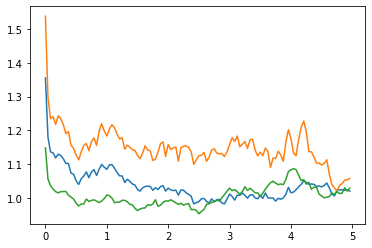

In [9]:
df = all_feature_list[5]
df['sleep_proxy'] =  (df["30-50 Hz"]+df["50-70 Hz"]+df["70-120 Hz"])/(df['1-4 Hz'] + df['4-8 Hz'])
predf = df[df['fname']<=20*3600*24]
posdf = df[df['fname']>20*3600*24]


sleep_proxy_signal = (df["30-50 Hz"]+df["50-70 Hz"]+df["70-120 Hz"])/(df['1-4 Hz'] + df['4-8 Hz'])
N = np.convolve(np.ones(sleep_proxy_signal.shape),np.ones(sleep_proxy_signal.shape))
psth = np.convolve(sleep_proxy_signal,sleep_proxy_signal[::-1])/N
psth = psth[int(len(psth)/2):]
psth = psth/np.mean(psth)
n = 24*5
t = np.arange(24*5)/24
plt.plot(t,psth[:n])

df = predf
sleep_proxy_signal = (df["30-50 Hz"]+df["50-70 Hz"]+df["70-120 Hz"])/(df['1-4 Hz'] + df['4-8 Hz'])
N = np.convolve(np.ones(sleep_proxy_signal.shape),np.ones(sleep_proxy_signal.shape))
psth = np.convolve(sleep_proxy_signal,sleep_proxy_signal[::-1])/N
psth = psth[int(len(psth)/2):]
psth = psth/np.mean(psth)
n = 24*5
t = np.arange(24*5)/24
plt.plot(t,psth[:n])

df = posdf
sleep_proxy_signal = (df["30-50 Hz"]+df["50-70 Hz"]+df["70-120 Hz"])/(df['1-4 Hz'] + df['4-8 Hz'])
N = np.convolve(np.ones(sleep_proxy_signal.shape),np.ones(sleep_proxy_signal.shape))
psth = np.convolve(sleep_proxy_signal,sleep_proxy_signal[::-1])/N
psth = psth[int(len(psth)/2):]
psth = psth/np.mean(psth)
n = 24*5
t = np.arange(24*5)/24
plt.plot(t,psth[:n])

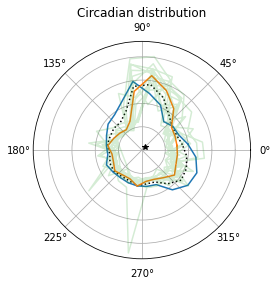

In [10]:
df = all_feature_list[7]
df['sleep_proxy'] =  (df["30-50 Hz"]+df["50-70 Hz"]+df["70-120 Hz"])/(df['1-4 Hz'] + df['4-8 Hz'])
predf = df[df['fname']<=20*3600*24]
posdf = df[df['fname']>20*3600*24]


plt.figure()
ax = plt.subplot(1,1,1,polar=True)
plt.title('Circadian distribution')
theta = np.linspace(0.0, 2 * np.pi, 24, endpoint=False) + np.pi/24

radii = np.array([np.mean(df[df['dayhour']==h]['sleep_proxy']) for h in range(24)])
bars = ax.plot(np.concatenate([theta,[theta[0]]]), np.concatenate([radii,[radii[0]]]),'k:')
center_of_mass = np.mean(radii*np.exp(1j*theta))
ax.plot(np.angle(center_of_mass),np.abs(center_of_mass),'k*')

radii = np.array([np.mean(predf[predf['dayhour']==h]['sleep_proxy']) for h in range(24)])
bars = ax.plot(np.concatenate([theta,[theta[0]]]), np.concatenate([radii,[radii[0]]]))

radii = np.array([np.mean(posdf[posdf['dayhour']==h]['sleep_proxy']) for h in range(24)])
ax.plot(np.concatenate([theta,[theta[0]]]), np.concatenate([radii,[radii[0]]]))

plt.plot((posdf['dayhour']+.5)/24*2*np.pi,posdf['sleep_proxy'],alpha=0.2)

ax.axes.yaxis.set_ticklabels([]);


In [11]:
def psth(events,signal):
    t = np.arange(-24*4 , 24*1)/24
    psth_sz = np.zeros((24*5))
    N=0
    M=0

    for sz in events:
        try:
            psth_sz += signal[int(sz/3600) -24*3: int(sz/3600) +24*2 ]
            N +=1
        except:
            M +=1
    print('counted',N,'events, skipped',M)
    return psth_sz,t

In [12]:
animal_group_dict

{'49': 'KV1.1',
 '213': 'KV1.1',
 '205': 'GFP',
 '94': 'KV1.1',
 '50': 'Kir2.1',
 '52': 'Kir2.1',
 '211': 'KV1.1',
 '104': 'GFP',
 '214': 'GFP',
 '99': 'KV1.1',
 '44': 'Kir2.1',
 '215': 'GFP',
 '212': 'GFP',
 '193': 'KV1.1',
 '51': 'KV1.1',
 '210': 'GFP',
 '45': 'Kir2.1'}

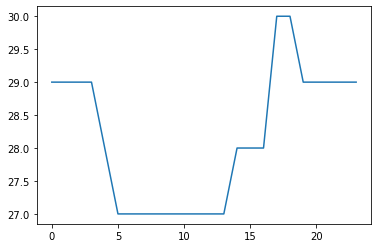

In [13]:


hourly_nfiles,t = np.histogram((all_animals_files[0]/3600)%24,bins=np.arange(0,25))
plt.plot(hourly_nfiles)

In [14]:
import matplotlib.transforms as mtransforms




 ./YQ data for Marco/205_YQ_True_dex.pkl GFP
counted 14 events, skipped 5
counted 3 events, skipped 0


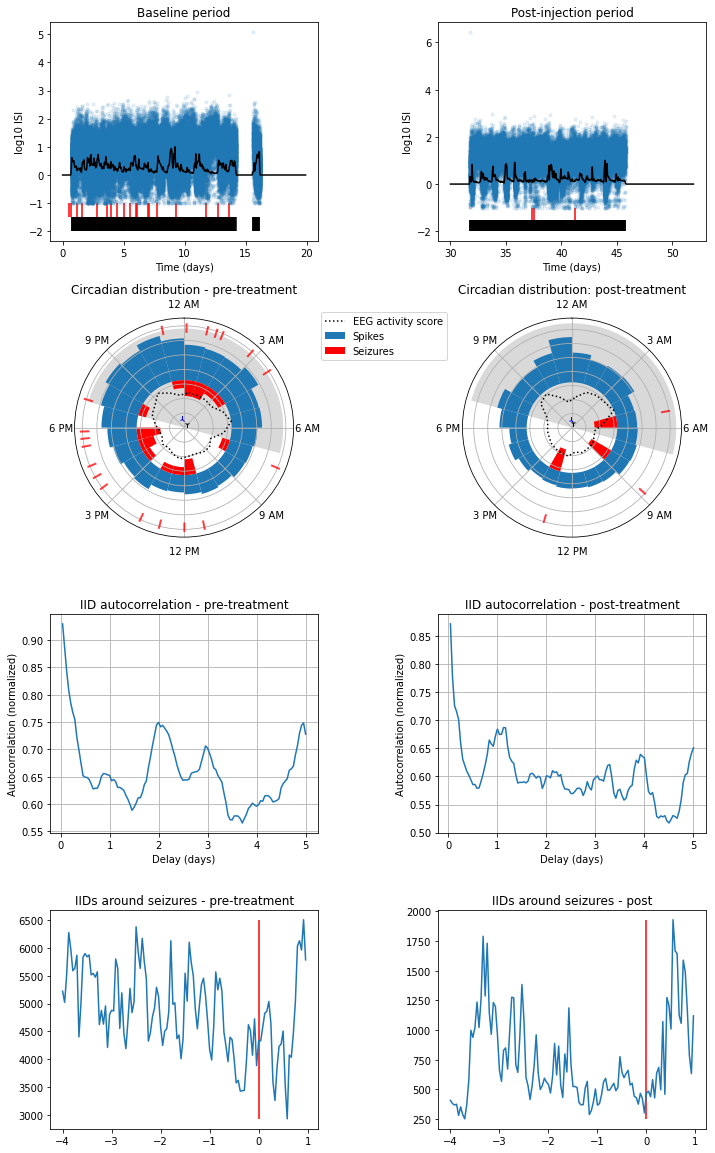




 ./YQ data for Marco/104_YQ_True_dex.pkl GFP
counted 31 events, skipped 4
counted 30 events, skipped 2


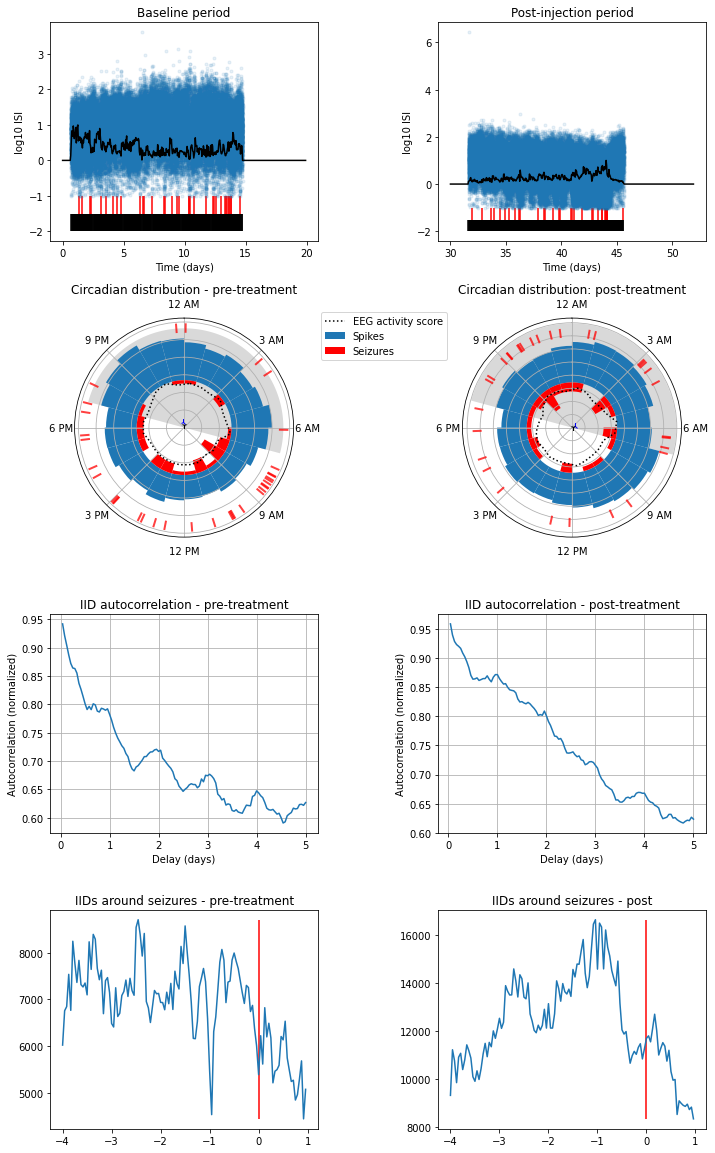




 ./YQ data for Marco/214_YQ_True_dex.pkl GFP
counted 6 events, skipped 0
counted 4 events, skipped 0


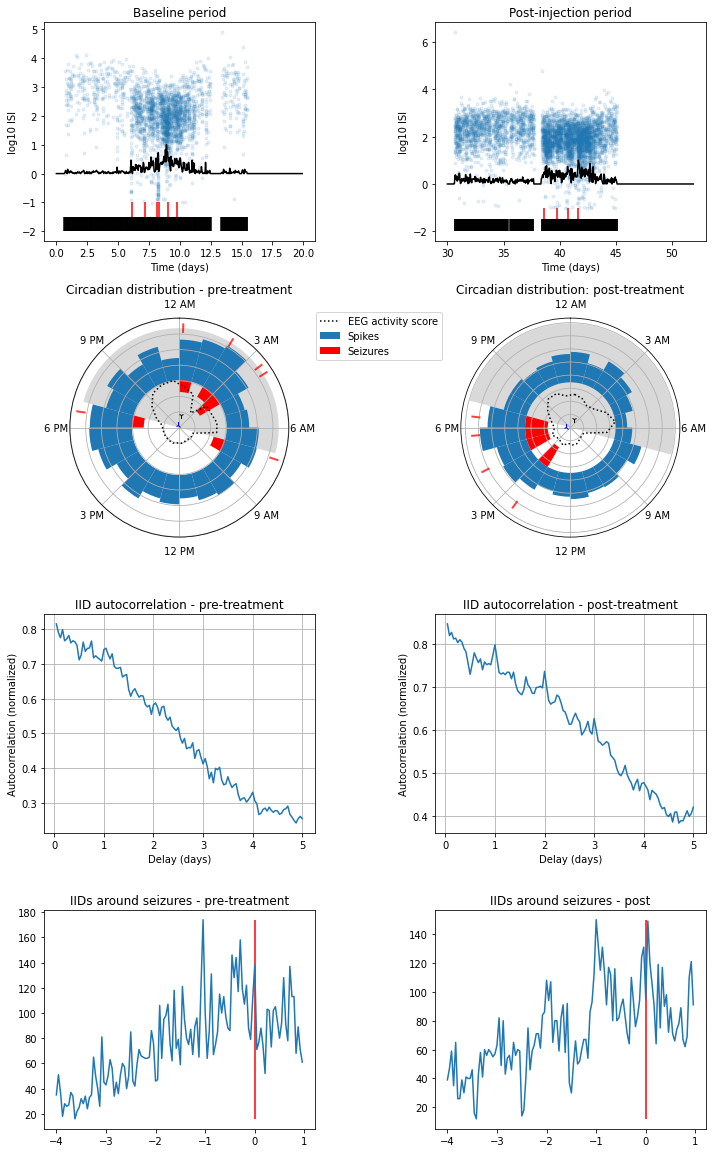




 ./YQ data for Marco/215_YQ_True_dex.pkl GFP
no seizures for polar plot
counted 6 events, skipped 3
counted 0 events, skipped 0


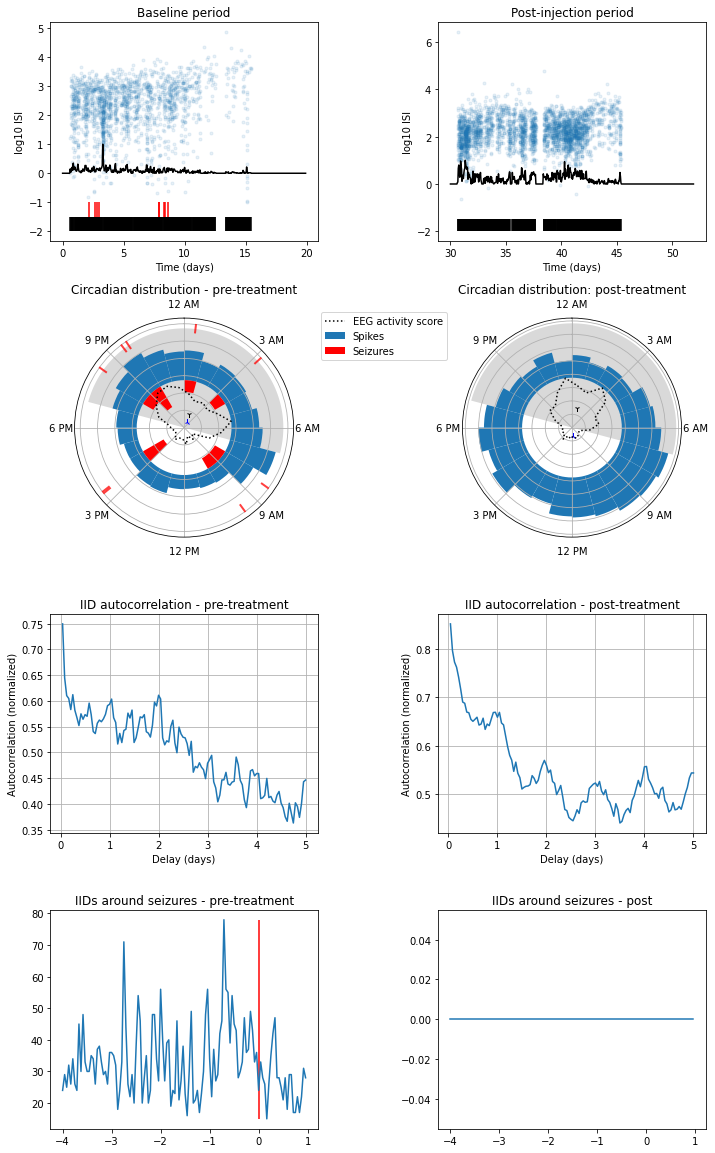




 ./YQ data for Marco/212_YQ_True_dex.pkl GFP
counted 73 events, skipped 19
counted 71 events, skipped 8


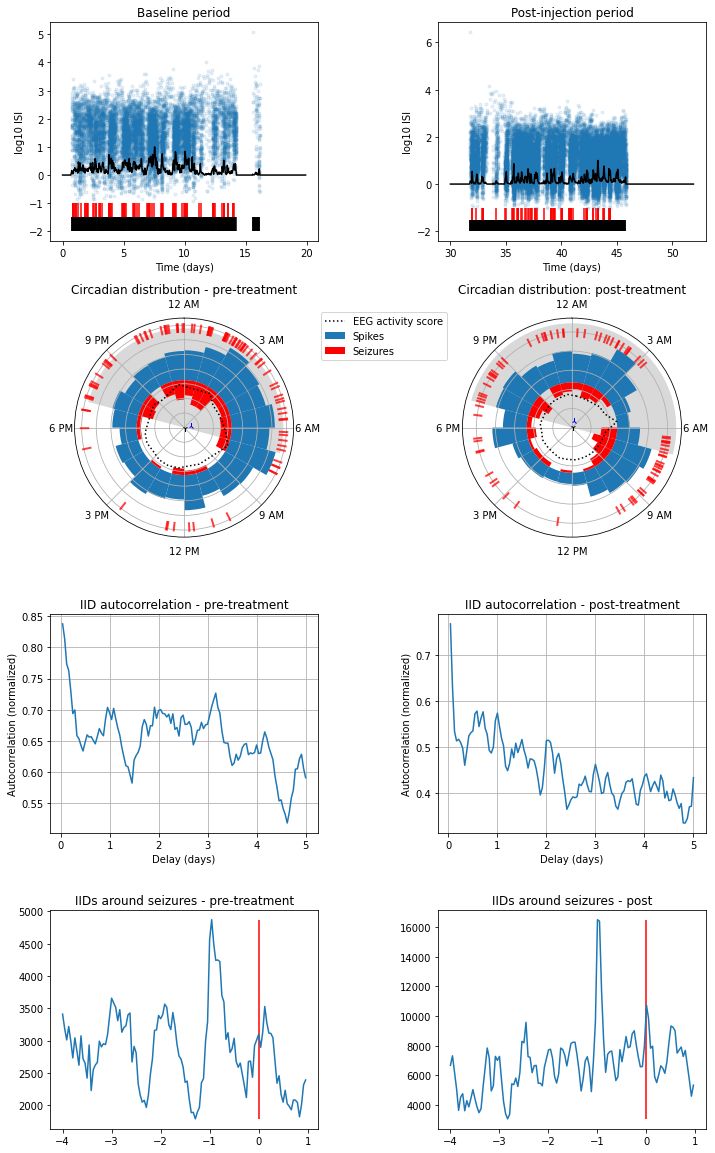




 ./YQ data for Marco/210_YQ_True_dex.pkl GFP
counted 34 events, skipped 3
counted 9 events, skipped 0


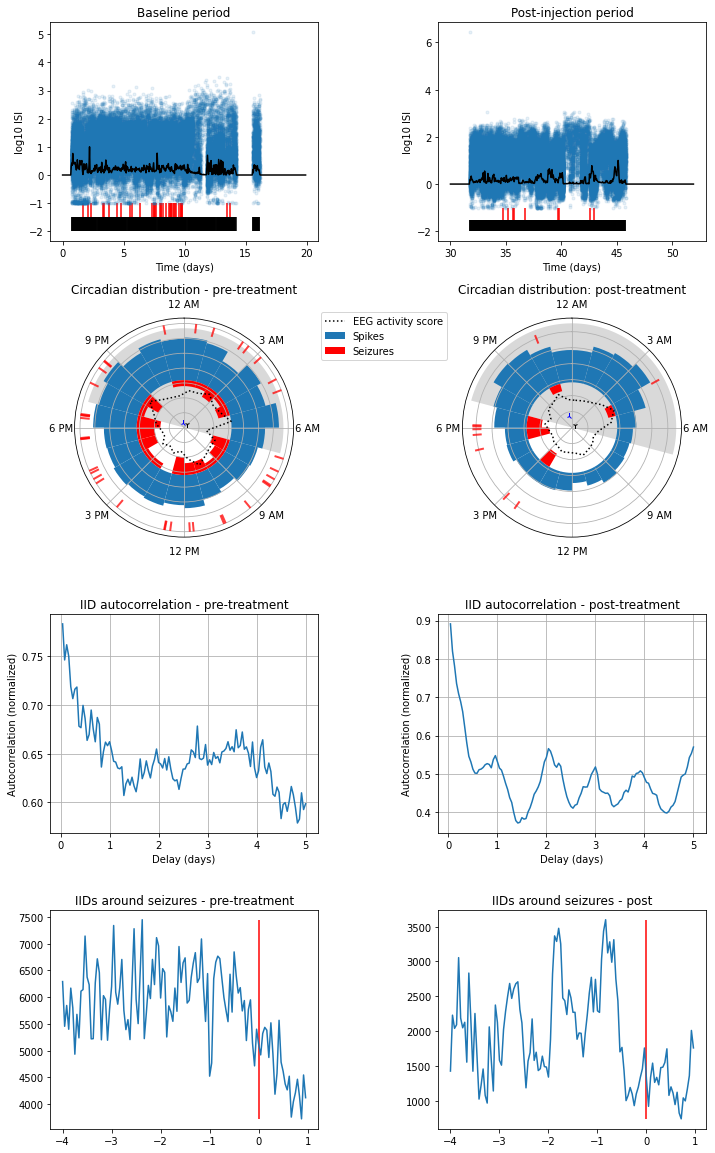




 ./YQ data for Marco/49_YQ_True_dex.pkl KV1.1
counted 56 events, skipped 18
counted 1 events, skipped 0


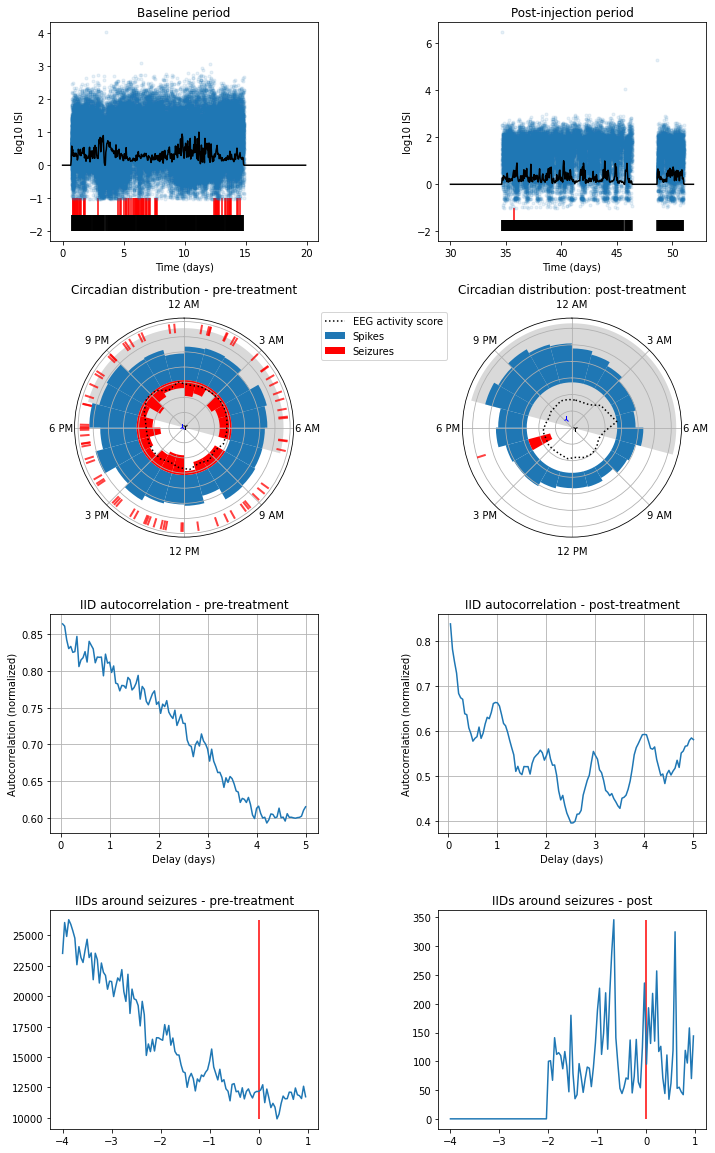




 ./YQ data for Marco/213_YQ_True_dex.pkl KV1.1
no seizures for polar plot
counted 17 events, skipped 0
counted 0 events, skipped 0


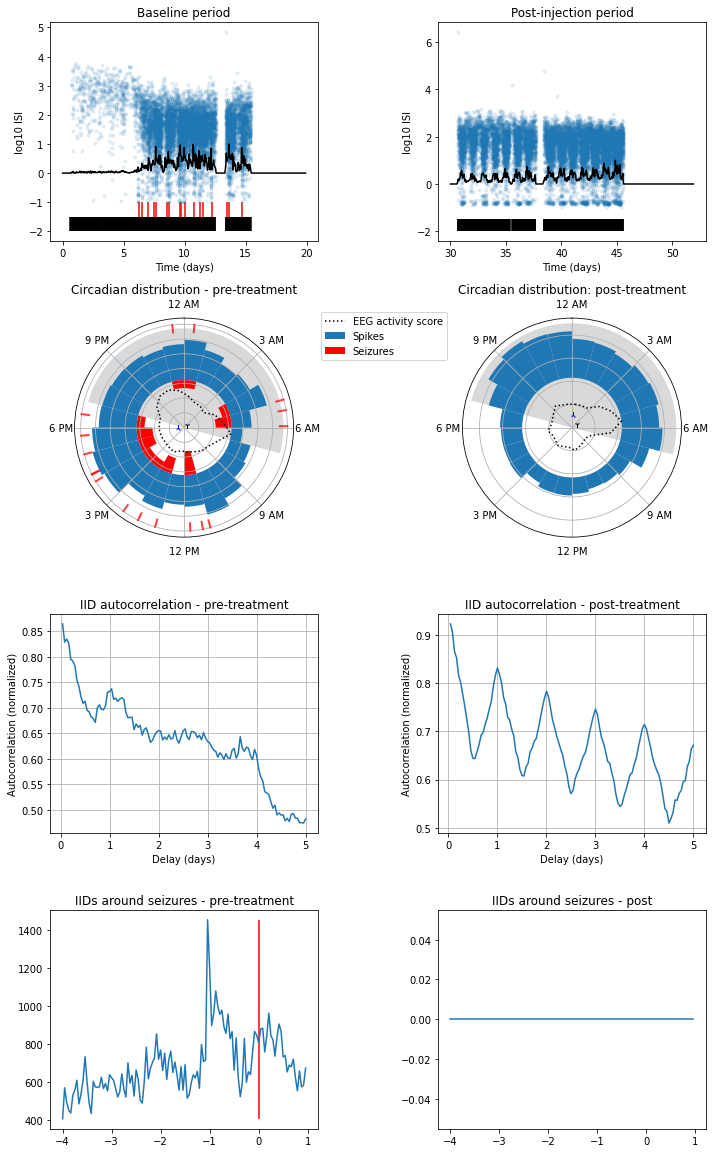




 ./YQ data for Marco/94_YQ_True_dex.pkl KV1.1
counted 131 events, skipped 20
counted 42 events, skipped 2


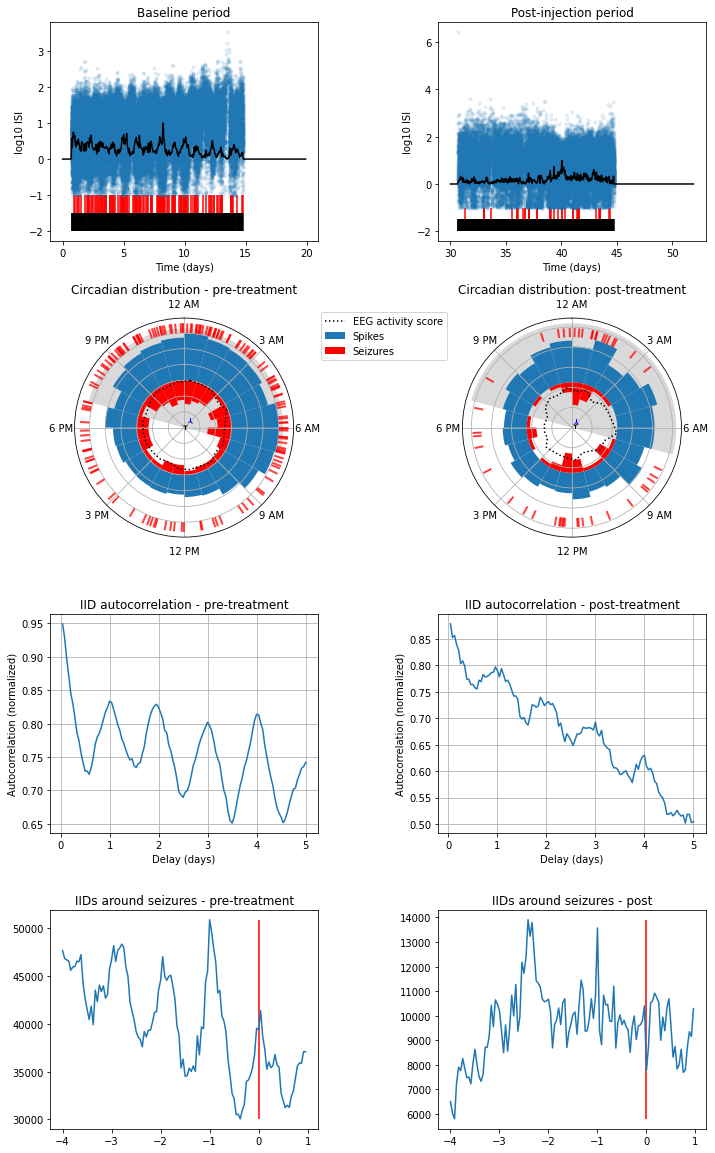




 ./YQ data for Marco/211_YQ_True_dex.pkl KV1.1
counted 17 events, skipped 6
counted 8 events, skipped 0


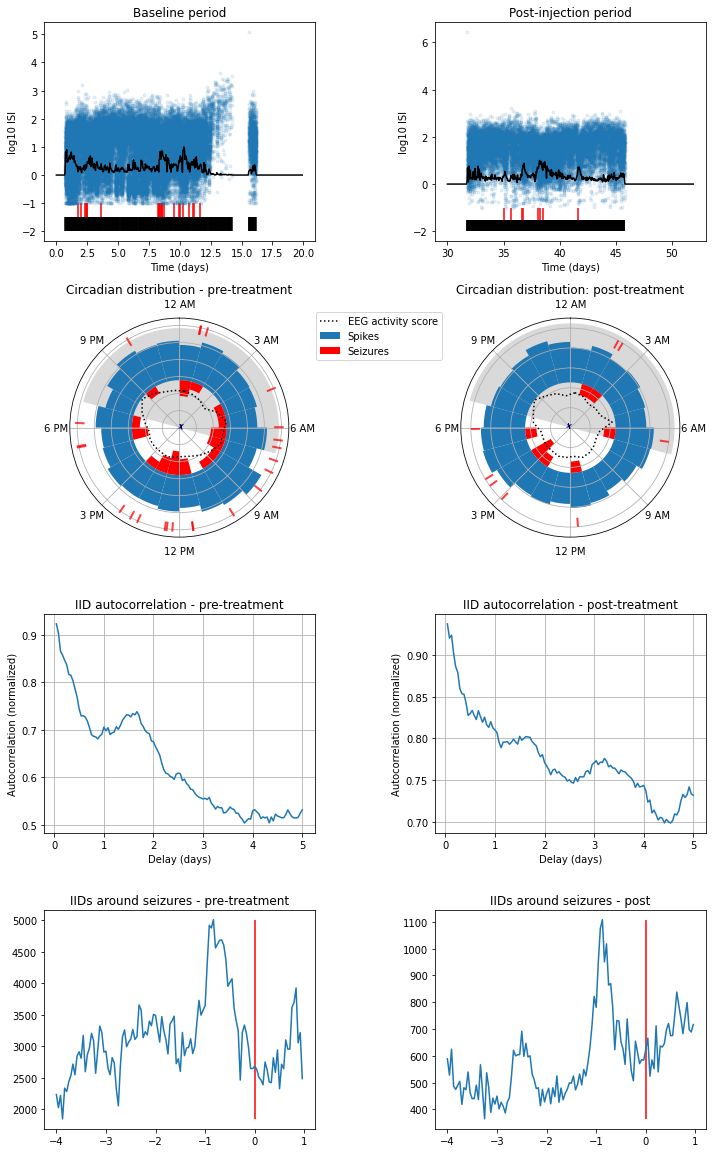




 ./YQ data for Marco/99_YQ_True_dex.pkl KV1.1
counted 7 events, skipped 4
counted 2 events, skipped 0


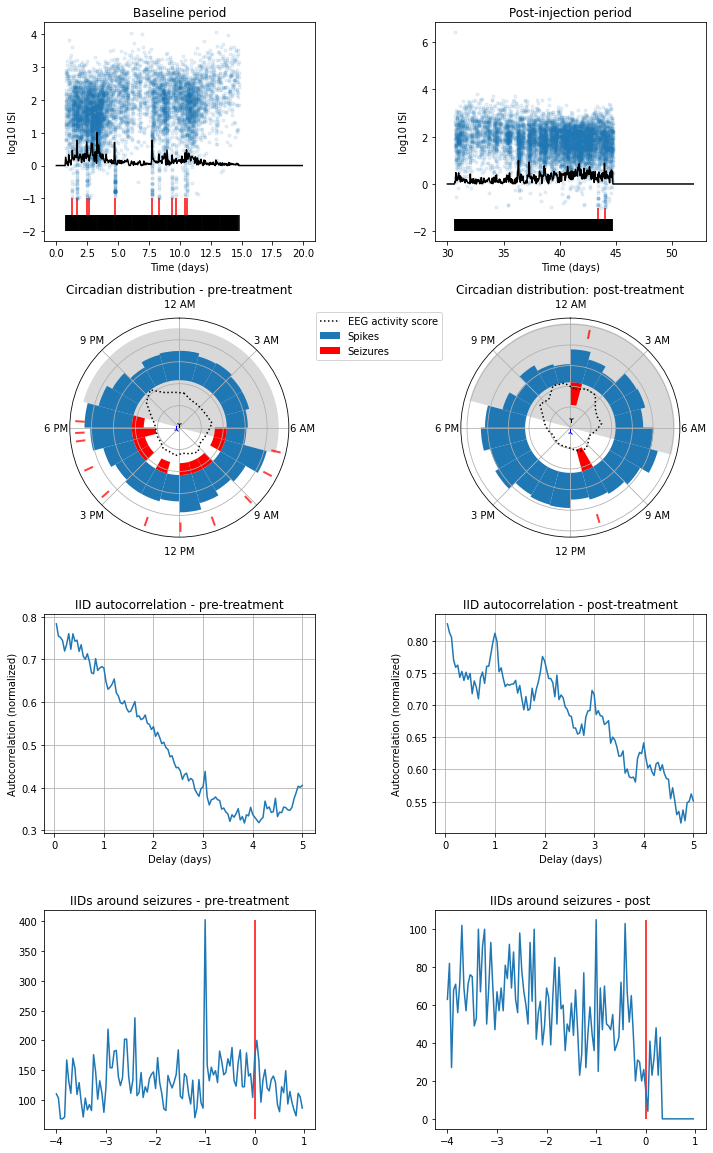




 ./YQ data for Marco/193_YQ_True_dex.pkl KV1.1
no seizures for polar plot
counted 27 events, skipped 7
counted 0 events, skipped 0


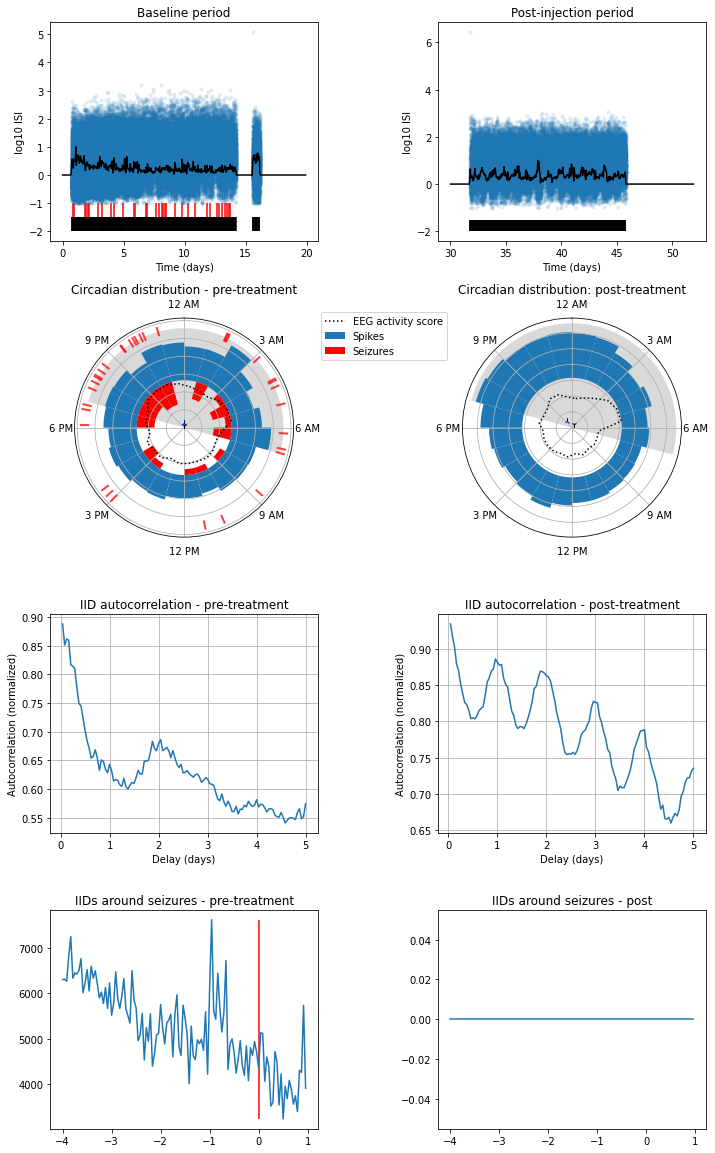




 ./YQ data for Marco/51_YQ_True_dex.pkl KV1.1
no seizures for polar plot
counted 80 events, skipped 34
counted 0 events, skipped 0


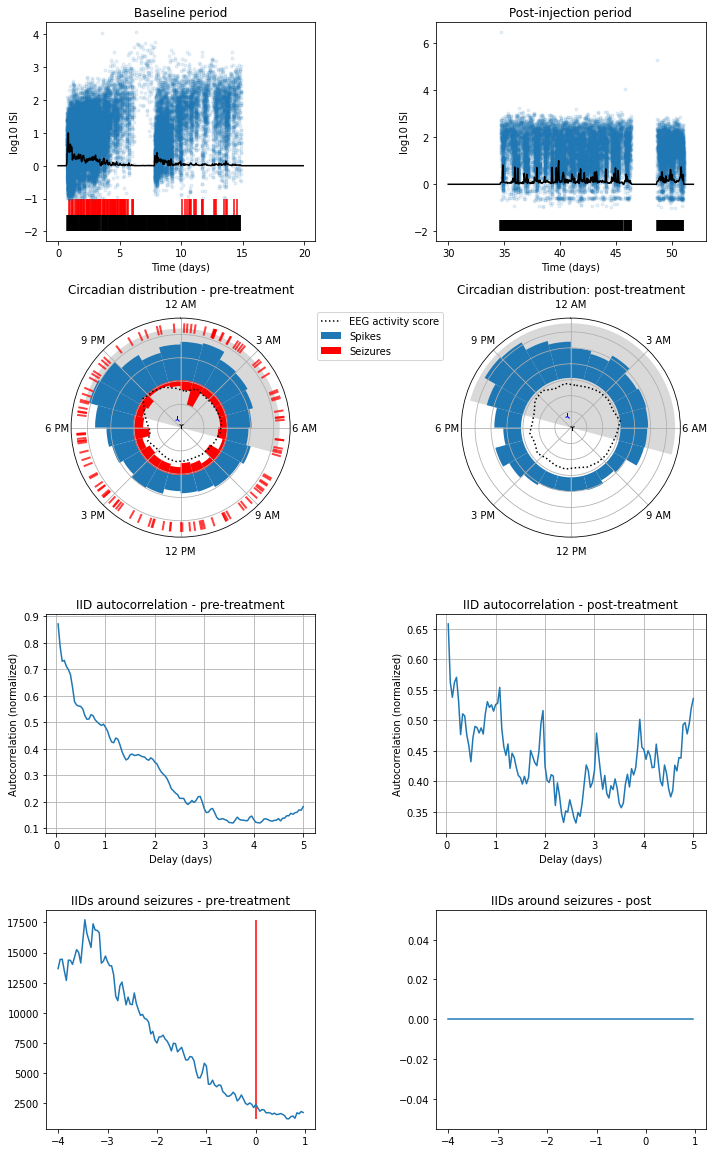




 ./YQ data for Marco/50_YQ_True_dex.pkl Kir2.1
no seizures for polar plot
no seizures for polar plot
counted 0 events, skipped 0
counted 0 events, skipped 0


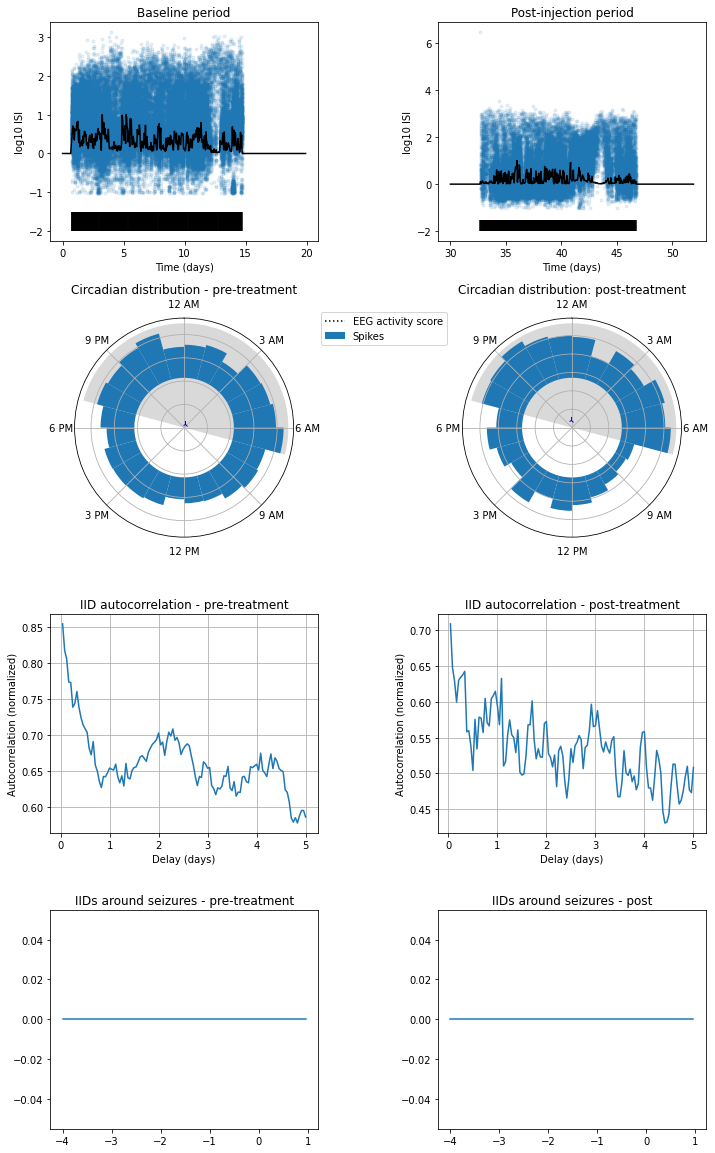




 ./YQ data for Marco/52_YQ_True_dex.pkl Kir2.1
no seizures for polar plot
no seizures for polar plot
counted 0 events, skipped 0
counted 0 events, skipped 0


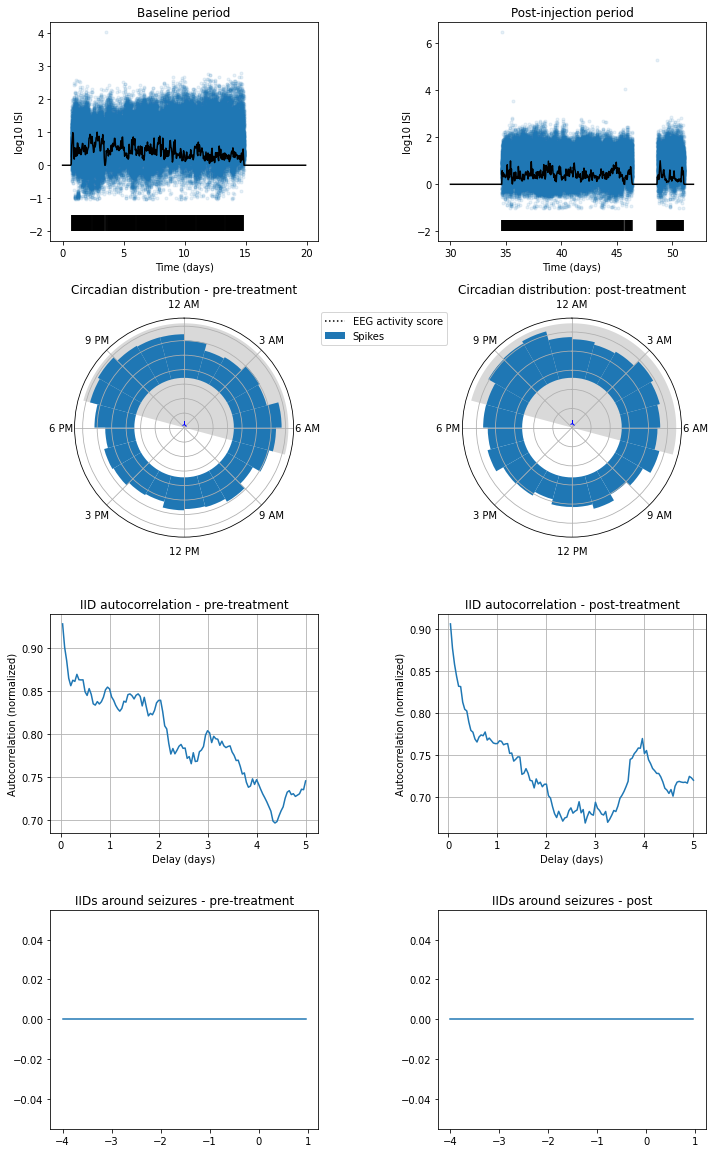




 ./YQ data for Marco/44_YQ_True_dex.pkl Kir2.1
no seizures for polar plot
no seizures for polar plot
counted 0 events, skipped 0
counted 0 events, skipped 0


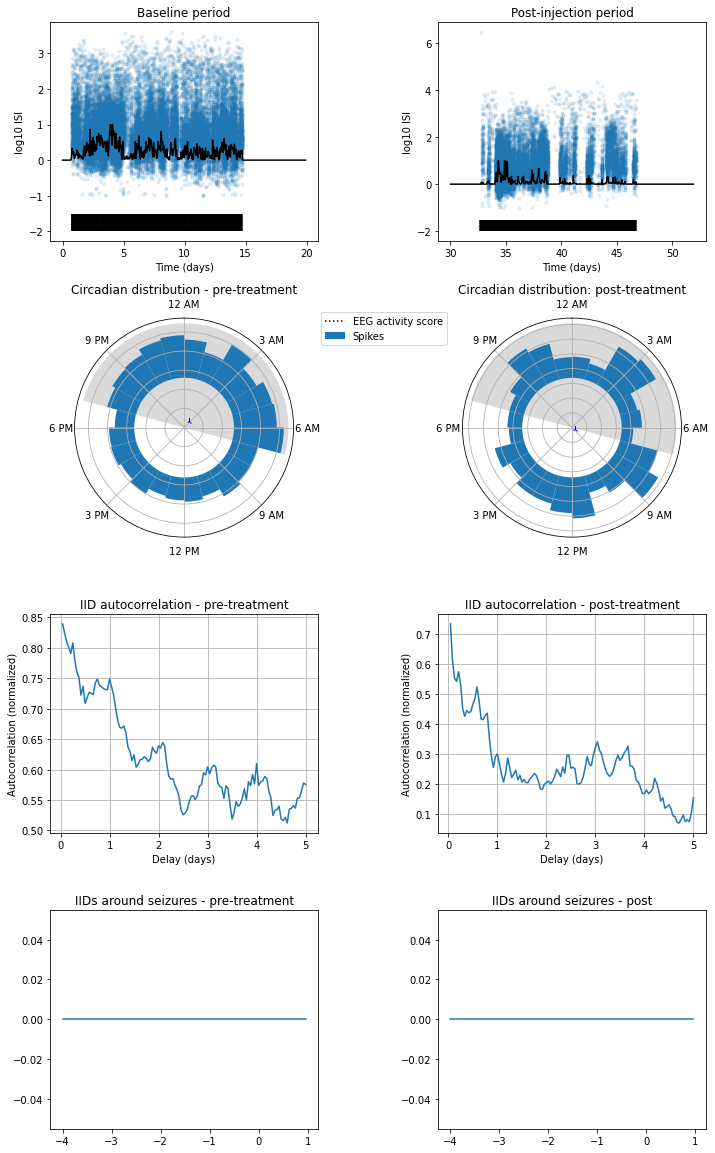




 ./YQ data for Marco/45_YQ_True_dex.pkl Kir2.1
no seizures for polar plot
no seizures for polar plot
counted 0 events, skipped 0
counted 0 events, skipped 0


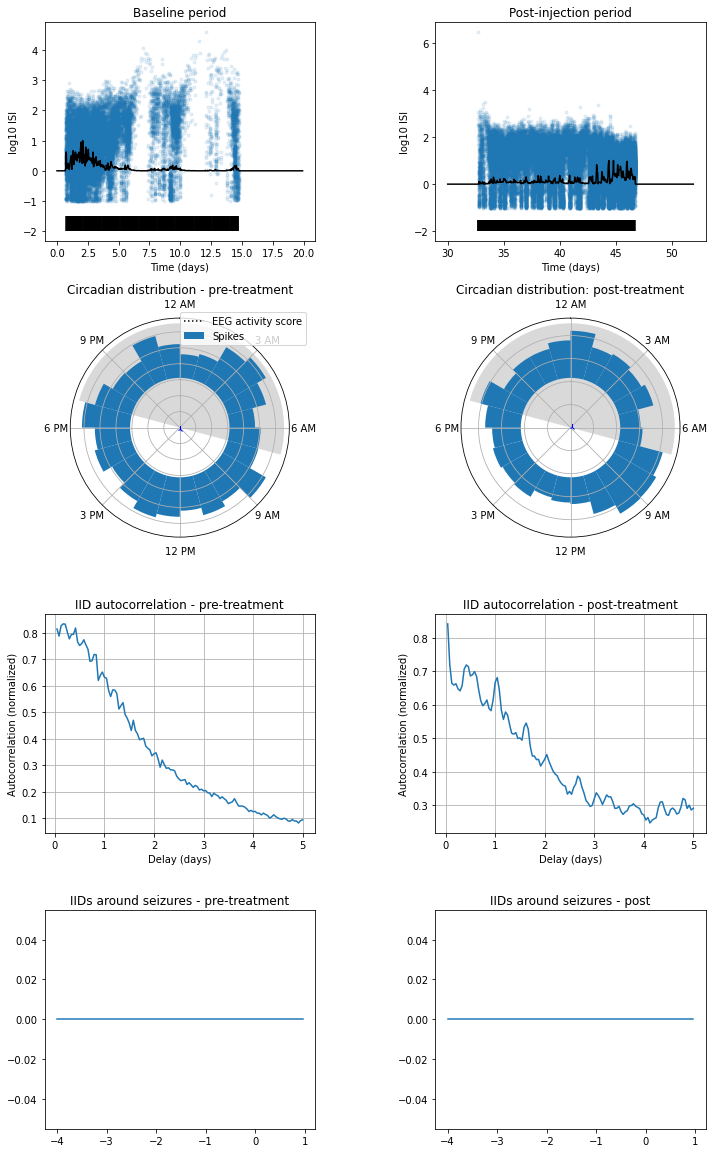

In [59]:
animal_circadian_spike_cm_dict = {}
animal_circadian_sleep_cm_dict = {}
animal_seizures_dict = {}
animal_baseline_seizure_hist_dict = {}

for i, data in enumerate(all_animals_evt):
#     print('\n\n\n',file_list[i])
    ainmal_id = get_animal.search(file_list[i]).group()[1:-3]
    print('\n\n\n',file_list[i],animal_group_dict[ainmal_id])
    if animal_group_dict[ainmal_id] != 'Kir2.1':
        df = all_feature_list[i]
        df['sleep_proxy'] =  (df["30-50 Hz"]+df["50-70 Hz"]+df["70-120 Hz"])/(df['1-4 Hz'] + df['4-8 Hz'])
        predf = df[df['fname']<=20*3600*24]
        posdf = df[df['fname']>20*3600*24]
    else:
        df = all_feature_list[0]
        df = 0*df
        df['sleep_proxy'] =  (df["30-50 Hz"]+df["50-70 Hz"]+df["70-120 Hz"])/(df['1-4 Hz'] + df['4-8 Hz'])
        predf = df[df['fname']<=20*3600*24]
        posdf = df[df['fname']>20*3600*24]
    
    fig = plt.figure(figsize=(10,20))
    
    plt.subplot(5,2,1)
    plt.title('Baseline period')
    baseline = data[data<20*3600*24]
    baseline_nfiles = all_animals_files[i][all_animals_files[i]<20*3600*24]
    
    hourly_baseline,t = np.histogram(baseline/3600,bins=np.arange(0,24*20))
    plt.plot(baseline/3600/24,np.log10(np.diff(baseline,prepend=baseline[0]-1)),'.',alpha=.1)
    plt.plot(t[:-1]/24,hourly_baseline/np.max(hourly_baseline),'k')
    baseline_files=all_animals_files[i][all_animals_files[i]<20*3600*24]
    plt.vlines(baseline_files/3600/24,-2,-1.5,'k')
    baseline_sz=all_seizure_list[i][all_seizure_list[i]<20*3600*24]
    plt.vlines(baseline_sz/3600/24,-1,-1.5,'r')
    plt.ylabel('log10 ISI')
    plt.xlabel('Time (days)')
    
    
#     plt.title(file_list[i])
    ax = plt.subplot(5,2,3,polar=True)
    plt.title('Circadian distribution - pre-treatment')
    theta = np.linspace(0.0, 2 * np.pi, 24, endpoint=False)+ np.pi/24
    radii,_ = np.histogram((baseline/3600)%24,bins=np.arange(0,25))
    radii_n,_ = np.histogram((baseline_nfiles/3600)%24,bins=np.arange(0,25))
#     radii = radii / radii_n
    
    width = (2*np.pi) / 24
    bottom = max(radii)/1
    bars = ax.bar(theta, radii, width=width, bottom=bottom,label='Spikes')
    center_of_mass_spike = np.sum(radii*np.exp(1j*theta))/np.sum(radii) #np.mean(radii*np.exp(1j*theta))/np.std(radii*np.exp(1j*theta))
    ax.plot(np.angle(center_of_mass_spike),np.abs(center_of_mass_spike)*bottom,'b2')
    
    # Make the labels go clockwise
    ax.set_theta_direction(-1)
    ax.set_theta_offset(np.pi/2)
    ax.set_xticks(np.linspace(0, 2*np.pi, 8, endpoint=False))
    ticks = ['12 AM', '3 AM', '6 AM', '9 AM','12 PM', '3 PM','6 PM', '9 PM',]
    ax.set_xticklabels(ticks)
    a,b = ax.get_ylim()
    ax.fill_between(np.linspace(np.pi*7/12,np.pi*19/12,100)+np.pi,0,b,facecolor='black', alpha=0.15,)


    
    if len(baseline_sz)>0:
        radii_sz_bl,_ = np.histogram((baseline_sz/3600)%24,bins=np.arange(0,25))
        bars = ax.bar(theta, -radii_sz_bl/max(radii_sz_bl)*bottom/2, width=width, bottom=bottom,color=[1,0,0],label='Seizures')
        ax.vlines(((baseline_sz/3600)/24)*2*np.pi,2*bottom,2.2*bottom,'r',alpha=.75,linewidth=2)
    else:
        radii_sz_bl = 0*np.arange(0,24)
        print('no seizures for polar plot')
        
    radii = np.array([np.mean(predf[predf['dayhour']==h]['sleep_proxy']) for h in range(24)])
    radii = radii/max(radii)*bottom
    bars = ax.plot(np.concatenate([theta,[theta[0]]]), np.concatenate([radii,[radii[0]]]),'k:',label='EEG activity score')
    center_of_mass_sleep = np.sum(radii*np.exp(1j*theta))/np.sum(radii)#np.mean(radii*np.exp(1j*theta))/np.std(radii*np.exp(1j*theta))
    ax.plot(np.angle(center_of_mass_sleep),np.abs(center_of_mass_sleep)*bottom,'k1')
    ax.legend(bbox_to_anchor=(1.1, 1.05))
    
    
    
    ax.axes.yaxis.set_ticklabels([])

    
    plt.subplot(5,2,5)
    plt.title('IID autocorrelation - pre-treatment')
    N = 24*5
    psth_baseline = np.convolve(hourly_baseline,hourly_baseline[::-1])/np.convolve(np.ones(hourly_baseline.shape),np.ones(hourly_baseline.shape))
    psth_baseline = psth_baseline/psth_baseline[len(psth_baseline)//2]
    plt.plot(t[1:N+1]/24,psth_baseline[len(psth_baseline)//2+1:len(psth_baseline)//2+1+N])
    plt.ylabel('Autocorrelation (normalized)')
    plt.xlabel('Delay (days)')
    plt.grid()
    
#     # Use custom colors and opacity
#     for r, bar in zip(radii, bars):
#         bar.set_facecolor(plt.cm.jet(r / 10.))
#         bar.set_alpha(0.8)

    plt.subplot(5,2,2)
    plt.title('Post-injection period')
    post = data[data>20*3600*24]
    post_nfiles = all_animals_files[i][all_animals_files[i]>20*3600*24]
    
    hourly_post,t = np.histogram(post/3600,bins=np.arange(30*24,24*52))
    plt.plot(post/3600/24,np.log10(np.diff(post,prepend=baseline[0]-1)),'.',alpha=.1)
    plt.plot(t[:-1]/24,hourly_post/np.max(hourly_post),'k')
    post_files=all_animals_files[i][all_animals_files[i]>20*3600*24]
    plt.vlines(post_files/3600/24,-2,-1.5,'k')
    post_sz=all_seizure_list[i][all_seizure_list[i]>20*3600*24]
    plt.vlines(post_sz/3600/24,-1,-1.5,'r')
    plt.ylabel('log10 ISI')
    plt.xlabel('Time (days)')
#     plt.title(file_list[i])
    
    ax = plt.subplot(5,2,4,polar=True)
    plt.title('Circadian distribution: post-treatment')
    theta = np.linspace(0.0, 2 * np.pi, 24, endpoint=False)+ np.pi/24
    width = (2*np.pi) / 24
    radii,_ = np.histogram((post/3600)%24,bins=np.arange(0,25))
    radii_n,_ = np.histogram((post_nfiles/3600)%24,bins=np.arange(0,25))
#     radii = radii / radii_n
    
    bottom = max(radii)/1
    bars = ax.bar(theta, radii, width=width, bottom=bottom)
    center_of_mass_spike_p = np.sum(radii*np.exp(1j*theta))/np.sum(radii)#np.mean(radii*np.exp(1j*theta))/np.std(radii*np.exp(1j*theta))
    ax.plot(np.angle(center_of_mass_spike_p),np.abs(center_of_mass_spike_p)*bottom,'b2')
    if len(post_sz)>0:
        radii_sz,_ = np.histogram((post_sz/3600)%24,bins=np.arange(0,25))
        bars = ax.bar(theta, -radii_sz/max(max(radii_sz),1)*bottom/2, width=width, bottom=bottom,color=[1,0,0])
        ax.vlines(((post_sz/3600)/24)*2*np.pi,2*bottom,2.2*bottom,'r',alpha=.75,linewidth=2)
    else:
        radii_sz = np.arange(0,24)*0
        print('no seizures for polar plot')
    
    radii = np.array([np.mean(posdf[posdf['dayhour']==h]['sleep_proxy']) for h in range(24)])
    radii = radii/max(radii)*bottom
    bars = ax.plot(np.concatenate([theta,[theta[0]]]), np.concatenate([radii,[radii[0]]]),'k:')
    center_of_mass_sleep_p = np.sum(radii*np.exp(1j*theta))/np.sum(radii)#np.mean(radii*np.exp(1j*theta))/np.std(radii*np.exp(1j*theta))
    ax.plot(np.angle(center_of_mass_sleep_p),np.abs(center_of_mass_sleep_p)*bottom,'k1')
    
    animal_circadian_spike_cm_dict[ainmal_id] = [center_of_mass_spike, center_of_mass_spike_p]
    animal_circadian_sleep_cm_dict[ainmal_id] = [center_of_mass_sleep, center_of_mass_sleep_p]
    animal_seizures_dict[ainmal_id]           = [len(baseline_sz), len(post_sz)]
    animal_baseline_seizure_hist_dict[ainmal_id] = [radii_sz_bl, radii_sz]
    
    ax.axes.yaxis.set_ticklabels([])
    # Make the labels go clockwise
    ax.set_theta_direction(-1)
    ax.set_theta_offset(np.pi/2)
    ax.set_xticks(np.linspace(0, 2*np.pi, 8, endpoint=False))
    ticks = ['12 AM', '3 AM', '6 AM', '9 AM','12 PM', '3 PM','6 PM', '9 PM',]
    ax.set_xticklabels(ticks)
    a,b = ax.get_ylim()
    ax.fill_between(np.linspace(np.pi*7/12,np.pi*19/12,100)+np.pi,0,b,facecolor='black', alpha=0.15,)
    
    trans = mtransforms.blended_transform_factory(ax.transData, ax.transAxes)
    ax.fill_between(theta,0,1, where=theta > np.pi*7/12,
                    facecolor='gray', alpha=0.5, transform=trans)

    
        
    plt.subplot(5,2,6)
    plt.title('IID autocorrelation - post-treatment')
    psth_post = np.convolve(hourly_post,hourly_post[::-1])/np.convolve(np.ones(hourly_post.shape),np.ones(hourly_post.shape))
    psth_post = psth_post/psth_post[len(psth_post)//2]
    t=t-t[0]
    plt.plot(t[1:N+1]/24,psth_post[len(psth_post)//2+1:len(psth_post)//2+1+N])
    plt.ylabel('Autocorrelation (normalized)')
    plt.xlabel('Delay (days)')
    plt.grid()
    
    plt.subplot(5,2,7)
    plt.title('IIDs around seizures - pre-treatment')
    psth_sz, t = psth(baseline_sz,hourly_baseline)
    plt.plot(t,psth_sz)
    plt.vlines(0,np.min(psth_sz),np.max(psth_sz),'r')
    
    plt.subplot(5,2,8)
    plt.title('IIDs around seizures - post')
    psth_sz, t = psth(post_sz-30*3600*24,hourly_post)
    plt.plot(t,psth_sz)
    plt.vlines(0,np.min(psth_sz),np.max(psth_sz),'r')
    
    fig.tight_layout()
    plt.show()
    
#     break
#     plt.xlim((0,5))

In [65]:
k = list(animal_baseline_seizure_hist_dict.keys())[0]
sz_hist_sum = 0*animal_baseline_seizure_hist_dict[k][0]

sz_hist_wmean = 0*animal_baseline_seizure_hist_dict[k][0].astype('float64')

for k in animal_baseline_seizure_hist_dict.keys():
    sz_hist_sum += animal_baseline_seizure_hist_dict[k][0]
    if np.sum(animal_baseline_seizure_hist_dict[k][0]) >0:
        sz_hist_wmean += animal_baseline_seizure_hist_dict[k][0]/np.sum(animal_baseline_seizure_hist_dict[k][0])
    print(k, np.sum(animal_baseline_seizure_hist_dict[k][0]))


205 19
104 35
214 6
215 9
212 92
210 37
49 74
213 17
94 151
211 23
99 11
193 34
51 114
50 0
52 0
44 0
45 0


In [66]:
animal_baseline_seizure_hist_dict.keys()

dict_keys(['205', '104', '214', '215', '212', '210', '49', '213', '94', '211', '99', '193', '51', '50', '52', '44', '45'])

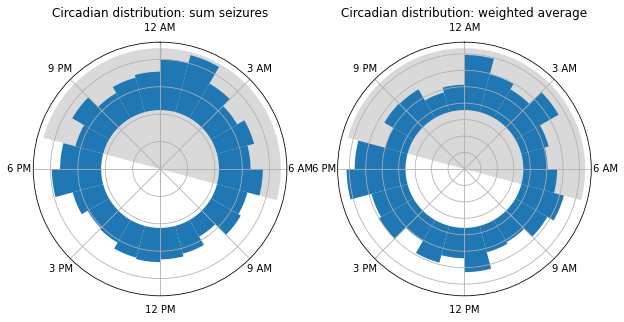

In [67]:
fig = plt.figure(figsize=(10,5))
ax = plt.subplot(1,2,1,polar=True)
plt.title('Circadian distribution: sum seizures')
theta = np.linspace(0.0, 2 * np.pi, 24, endpoint=False)+ np.pi/24
width = (2*np.pi) / 24
radii = sz_hist_sum
bottom = max(radii)/1
bars = ax.bar(theta, radii, width=width, bottom=bottom)

ax.axes.yaxis.set_ticklabels([])
# Make the labels go clockwise
ax.set_theta_direction(-1)
ax.set_theta_offset(np.pi/2)
ax.set_xticks(np.linspace(0, 2*np.pi, 8, endpoint=False))
ticks = ['12 AM', '3 AM', '6 AM', '9 AM','12 PM', '3 PM','6 PM', '9 PM',]
ax.set_xticklabels(ticks)
a,b = ax.get_ylim()
ax.fill_between(np.linspace(np.pi*7/12,np.pi*19/12,100)+np.pi,0,b,facecolor='black', alpha=0.15,)

trans = mtransforms.blended_transform_factory(ax.transData, ax.transAxes)
ax.fill_between(theta,0,1, where=theta > np.pi*7/12,
                facecolor='gray', alpha=0.5, transform=trans)



ax = plt.subplot(1,2,2,polar=True)
plt.title('Circadian distribution: weighted average')
theta = np.linspace(0.0, 2 * np.pi, 24, endpoint=False)+ np.pi/24
width = (2*np.pi) / 24
radii = sz_hist_wmean
bottom = max(radii)/1
bars = ax.bar(theta, radii, width=width, bottom=bottom)

ax.axes.yaxis.set_ticklabels([])
# Make the labels go clockwise
ax.set_theta_direction(-1)
ax.set_theta_offset(np.pi/2)
ax.set_xticks(np.linspace(0, 2*np.pi, 8, endpoint=False))
ticks = ['12 AM', '3 AM', '6 AM', '9 AM','12 PM', '3 PM','6 PM', '9 PM',]
ax.set_xticklabels(ticks)
a,b = ax.get_ylim()
ax.fill_between(np.linspace(np.pi*7/12,np.pi*19/12,100)+np.pi,0,b,facecolor='black', alpha=0.15,)

trans = mtransforms.blended_transform_factory(ax.transData, ax.transAxes)
# ax.fill_between(theta,0,1, where=theta > np.pi*7/12,
#                 facecolor='gray', alpha=0.5, transform=trans)


In [71]:
3.2/3.64*1.5

1.3186813186813187

In [72]:
3.2/3.64*.5

0.43956043956043955

In [70]:
3.64/3.2*.3

0.34125

In [16]:
gfp_keys = [k for k in animal_group_dict.keys() if animal_group_dict[k]=='GFP']
kv1_keys = [k for k in animal_group_dict.keys() if animal_group_dict[k]=='KV1.1']

Stats on GFP: (0.3565198349593078, 0.48787822263833724)
Stats on KV1: (0.5642380605202018, 0.18701020282090114)
Stats on ALL: (0.5309310299685587, 0.061915406417407635)
Stats on ALL: (0.18082562691224782, 0.5543928103860963)


<ipython-input-17-726a5d8a29e1>:130: UserWarning: tight_layout not applied: number of rows in subplot specifications must be multiples of one another.
  fig.tight_layout()


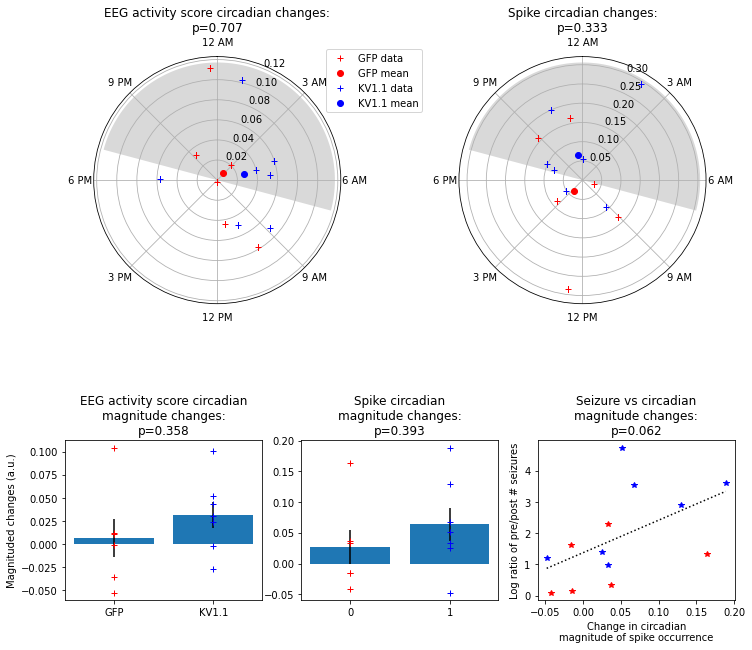

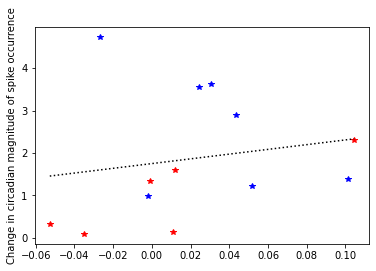

In [17]:


gfp_sleep_changes = [animal_circadian_sleep_cm_dict[k][1] - animal_circadian_sleep_cm_dict[k][0] for k in gfp_keys]
kv1_sleep_changes = [animal_circadian_sleep_cm_dict[k][1] - animal_circadian_sleep_cm_dict[k][0] for k in kv1_keys]
gfp_spike_changes = [animal_circadian_spike_cm_dict[k][1] - animal_circadian_spike_cm_dict[k][0] for k in gfp_keys]
kv1_spike_changes = [animal_circadian_spike_cm_dict[k][1] - animal_circadian_spike_cm_dict[k][0] for k in kv1_keys]


# Stats
data1 = np.array((np.real(gfp_sleep_changes),np.imag(gfp_sleep_changes))).T
data2 = np.array((np.real(kv1_sleep_changes),np.imag(kv1_sleep_changes))).T

full_data = np.concatenate((data1,data2))
rss0 = np.sum((full_data-np.mean(full_data,axis=0))**2)

full_data_m = np.concatenate((data1 - np.mean(data1,axis=0), data2 - np.mean(data2,axis=0)))
rss1 = np.sum(full_data_m**2)
F = (rss0-rss1)/rss1*(2*len(full_data)-4)/2 # F-value for model with same mean vs different means
p_value_sleep = (1 - f_dist.cdf(F, 2, (2*len(full_data)-4)))
# print('Sleep changes p_value', p_value_sleep)

data1 = np.array((np.real(gfp_spike_changes),np.imag(gfp_spike_changes))).T
data2 = np.array((np.real(kv1_spike_changes),np.imag(kv1_spike_changes))).T

full_data = np.concatenate((data1,data2))
rss0 = np.sum((full_data-np.mean(full_data,axis=0))**2)

full_data_m = np.concatenate((data1 - np.mean(data1,axis=0), data2 - np.mean(data2,axis=0)))
rss1 = np.sum(full_data_m**2)
F = (rss0-rss1)/rss1*(2*len(full_data)-4)/2 # F-value for model with same mean vs different means
p_value_spike = (1 - f_dist.cdf(F, 2, (2*len(full_data)-4)))
# print('Spike changes p_value', p_value_spike)


# Plots

fig = plt.figure(figsize=(12,10))

ax = plt.subplot(2,2,1,polar=True)
plt.title(f'EEG activity score circadian changes:\np={p_value_sleep:.3f}')

ax.plot(np.angle(gfp_sleep_changes),np.abs(gfp_sleep_changes),'+r',label='GFP data')
ax.plot(np.angle(np.mean(gfp_sleep_changes)),np.abs(np.mean(gfp_sleep_changes)),'or',label='GFP mean')

ax.plot(np.angle(kv1_sleep_changes),np.abs(kv1_sleep_changes),'+b',label='KV1.1 data')
ax.plot(np.angle(np.mean(kv1_sleep_changes)),np.abs(np.mean(kv1_sleep_changes)),'ob',label='KV1.1 mean')
ax.legend(bbox_to_anchor=(1.35, 1.05))

ax.set_theta_direction(-1)
ax.set_theta_offset(np.pi/2)
ax.set_xticks(np.linspace(0, 2*np.pi, 8, endpoint=False))
ticks = ['12 AM', '3 AM', '6 AM', '9 AM','12 PM', '3 PM','6 PM', '9 PM',]
ax.set_xticklabels(ticks)
a,b = ax.get_ylim()
ax.fill_between(np.linspace(np.pi*7/12,np.pi*19/12,100)+np.pi,0,b,facecolor='black', alpha=0.15,)

ax = plt.subplot(2,2,2,polar=True)
plt.title(f'Spike circadian changes:\np={p_value_spike:.3f}')

ax.plot(np.angle(gfp_spike_changes),np.abs(gfp_spike_changes),'+r',label='GFP data')
ax.plot(np.angle(np.mean(gfp_spike_changes)),np.abs(np.mean(gfp_spike_changes)),'or',label='GFP mean')

ax.plot(np.angle(kv1_spike_changes),np.abs(kv1_spike_changes),'+b',label='KV1.1 data')
ax.plot(np.angle(np.mean(kv1_spike_changes)),np.abs(np.mean(kv1_spike_changes)),'ob',label='KV1.1 mean')
# plt.legend()

ax.set_theta_direction(-1)
ax.set_theta_offset(np.pi/2)
ax.set_xticks(np.linspace(0, 2*np.pi, 8, endpoint=False))
ticks = ['12 AM', '3 AM', '6 AM', '9 AM','12 PM', '3 PM','6 PM', '9 PM',]
ax.set_xticklabels(ticks)
a,b = ax.get_ylim()
ax.fill_between(np.linspace(np.pi*7/12,np.pi*19/12,100)+np.pi,0,b,facecolor='black', alpha=0.15,)


# stats just with amplitudes
gfp_sleep_changes = [np.abs(animal_circadian_sleep_cm_dict[k][1]) - np.abs(animal_circadian_sleep_cm_dict[k][0]) for k in gfp_keys]
kv1_sleep_changes = [np.abs(animal_circadian_sleep_cm_dict[k][1]) - np.abs(animal_circadian_sleep_cm_dict[k][0]) for k in kv1_keys]
gfp_spike_changes = [np.abs(animal_circadian_spike_cm_dict[k][1]) - np.abs(animal_circadian_spike_cm_dict[k][0]) for k in gfp_keys]
kv1_spike_changes = [np.abs(animal_circadian_spike_cm_dict[k][1]) - np.abs(animal_circadian_spike_cm_dict[k][0]) for k in kv1_keys]


ax = plt.subplot(3,3,7)
r = stats.ttest_ind(gfp_sleep_changes,kv1_sleep_changes)
plt.title(f'EEG activity score circadian\nmagnitude changes:\np={r.pvalue:.3f}')
plt.bar([0,1],[np.mean(gfp_sleep_changes),np.mean(kv1_sleep_changes)],
        yerr=[np.std(gfp_sleep_changes)/np.sqrt(len(gfp_sleep_changes)),np.std(kv1_sleep_changes)/np.sqrt(len(kv1_sleep_changes))])
plt.plot(np.zeros(len(gfp_sleep_changes)),gfp_sleep_changes,'r+',label='GFP data')
plt.plot(np.zeros(len(kv1_sleep_changes))+1,kv1_sleep_changes,'b+',label='KV1.1 data')
ax.set_xticks([0,1])
ticks = ['GFP', 'KV1.1']
ax.set_xticklabels(ticks)
plt.ylabel('Magnituded changes (a.u.)')
# plt.legend()

ax = plt.subplot(3,3,8)
r = stats.ttest_ind(gfp_spike_changes,kv1_spike_changes)
plt.title(f'Spike circadian\nmagnitude changes:\np={r.pvalue:.3f}')
plt.bar([0,1],[np.mean(gfp_spike_changes),np.mean(kv1_spike_changes)],
        yerr=[np.std(gfp_spike_changes)/np.sqrt(len(gfp_spike_changes)),np.std(kv1_spike_changes)/np.sqrt(len(kv1_spike_changes))])
plt.plot(np.zeros(len(gfp_spike_changes)),gfp_spike_changes,'r+',label='GFP data')
plt.plot(np.zeros(len(kv1_spike_changes))+1,kv1_spike_changes,'b+',label='KV1.1 data')
ax.set_xticks([0,1])
ticks = ['GFP', 'KV1.1']
# plt.legend()

data_gfp_sz = [np.log(animal_seizures_dict[k][0]+1)- np.log(animal_seizures_dict[k][1]+1) for k in gfp_keys]
data_kv1_sz = [np.log(animal_seizures_dict[k][0]+1)- np.log(animal_seizures_dict[k][1]+1) for k in kv1_keys]

# data_gfp_sz = [animal_seizures_dict[k][1]/animal_seizures_dict[k][0] for k in gfp_keys]
# data_kv1_sz = [animal_seizures_dict[k][1]/animal_seizures_dict[k][0] for k in kv1_keys]

print('Stats on GFP:', stats.pearsonr(gfp_spike_changes,data_gfp_sz))
print('Stats on KV1:', stats.pearsonr(kv1_spike_changes,data_kv1_sz))
x,y = (np.concatenate((gfp_spike_changes,kv1_spike_changes)),np.concatenate((data_gfp_sz,data_kv1_sz)))
r,p = stats.pearsonr(x,y)
print('Stats on ALL:', (r,p))

poly = np.polyfit(x,y,1)

ax = plt.subplot(3,3,9)
# plt.figure()
plt.plot(gfp_spike_changes,data_gfp_sz,'*r')
plt.plot(kv1_spike_changes,data_kv1_sz,'*b')
plt.ylabel('Log ratio of pre/post # seizures')
plt.xlabel('Change in circadian\nmagnitude of spike occurrence')
plt.title(f'Seizure vs circadian\nmagnitude changes:\np={p:.3f}')
a = np.array((min(x),max(x)))
plt.plot(a,a*poly[0]+poly[1],'k:')


fig.tight_layout()


plt.figure()
# plt.plot(gfp_sleep_changes,gfp_spike_changes,'*r')
# plt.plot(kv1_sleep_changes,kv1_spike_changes,'*b')
plt.plot(gfp_sleep_changes,data_gfp_sz,'*r')
plt.plot(kv1_sleep_changes,data_kv1_sz,'*b')

plt.ylabel('Change in circadian magnitude of sleep occurrence')
plt.ylabel('Change in circadian magnitude of spike occurrence')
x,y = (np.concatenate((gfp_sleep_changes,kv1_sleep_changes)),np.concatenate((data_gfp_sz,data_kv1_sz)))
r,p = stats.pearsonr(x,y)
print('Stats on ALL:', (r,p))
poly = np.polyfit(x,y,1)
a = np.array((min(x),max(x)))
plt.plot(a,a*poly[0]+poly[1],'k:')

In [18]:
poly

array([5.57808422, 1.7508819 ])

In [19]:
np.concatenate((kv1_spike_changes,gfp_spike_changes))

array([ 0.18874148,  0.12974078, -0.04785704,  0.0332154 ,  0.02474052,
        0.06817133,  0.05128574, -0.01566511, -0.04184997,  0.03649445,
        0.03318734, -0.01478588,  0.16359678])

(-0.4, 0.4)

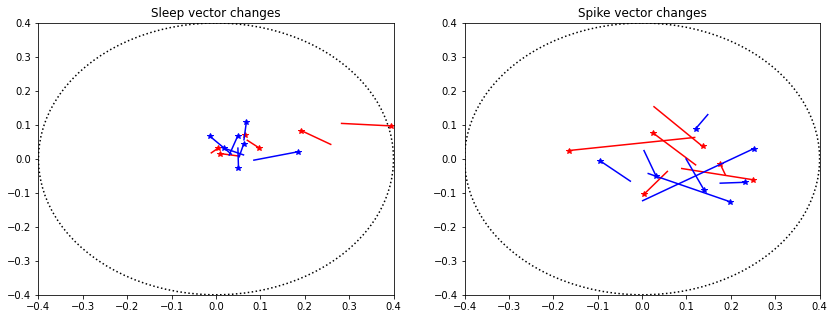

In [20]:
gfp_sleep_changes = [(animal_circadian_sleep_cm_dict[k][1],animal_circadian_sleep_cm_dict[k][0]) for k in gfp_keys]
kv1_sleep_changes = [(animal_circadian_sleep_cm_dict[k][1],animal_circadian_sleep_cm_dict[k][0]) for k in kv1_keys]
gfp_spike_changes = [(animal_circadian_spike_cm_dict[k][1],animal_circadian_spike_cm_dict[k][0]) for k in gfp_keys]
kv1_spike_changes = [(animal_circadian_spike_cm_dict[k][1],animal_circadian_spike_cm_dict[k][0]) for k in kv1_keys]

plt.figure(figsize=(14,5))

data1 = np.array((np.real(gfp_sleep_changes),np.imag(gfp_sleep_changes))).T
data2 = np.array((np.real(kv1_sleep_changes),np.imag(kv1_sleep_changes))).T

plt.subplot(1,2,1,polar=False)
plt.title('Sleep vector changes')
for i in range(data1.shape[1]):
    plt.plot([data1[0][i][0],data1[1][i][0]],[data1[0][i][1],data1[1][i][1]],'r')
    plt.plot([data1[0][i][0]],[data1[0][i][1]],'*r')
    
for i in range(data2.shape[1]):
    plt.plot([data2[0][i][0],data2[1][i][0]],[data2[0][i][1],data2[1][i][1]],'b')
    plt.plot([data2[0][i][0]],[data2[0][i][1]],'*b')
    
t = np.linspace(0,2*np.pi,100)
r=0.4
plt.plot(r*np.sin(t),r*np.cos(t),'k:')
plt.ylim([-r,r])
plt.xlim([-r,r])


data1 = np.array((np.real(gfp_spike_changes),np.imag(gfp_spike_changes))).T
data2 = np.array((np.real(kv1_spike_changes),np.imag(kv1_spike_changes))).T

plt.subplot(1,2,2,polar=False)
plt.title('Spike vector changes')
for i in range(data1.shape[1]):
    plt.plot([data1[0][i][0],data1[1][i][0]],[data1[0][i][1],data1[1][i][1]],'r')
    plt.plot([data1[0][i][0]],[data1[0][i][1]],'*r')
    
for i in range(data2.shape[1]):
    plt.plot([data2[0][i][0],data2[1][i][0]],[data2[0][i][1],data2[1][i][1]],'b')
    plt.plot([data2[0][i][0]],[data2[0][i][1]],'*b')
    
t = np.linspace(0,2*np.pi,100)
r=0.4
plt.plot(r*np.sin(t),r*np.cos(t),'k:')
plt.ylim([-r,r])
plt.xlim([-r,r])


In [19]:


gfp_sleep_changes = [(animal_circadian_sleep_cm_dict[k][1],animal_circadian_sleep_cm_dict[k][0]-animal_circadian_sleep_cm_dict[k][1]) for k in gfp_keys]
kv1_sleep_changes = [(animal_circadian_sleep_cm_dict[k][1],animal_circadian_sleep_cm_dict[k][0]-animal_circadian_sleep_cm_dict[k][1]) for k in kv1_keys]
gfp_spike_changes = [(animal_circadian_spike_cm_dict[k][1],animal_circadian_spike_cm_dict[k][0]-animal_circadian_spike_cm_dict[k][1]) for k in gfp_keys]
kv1_spike_changes = [(animal_circadian_spike_cm_dict[k][1],animal_circadian_spike_cm_dict[k][0]-animal_circadian_spike_cm_dict[k][1]) for k in kv1_keys]


# Stats
data1 = np.array((np.real(gfp_sleep_changes),np.imag(gfp_sleep_changes))).T
data2 = np.array((np.real(kv1_sleep_changes),np.imag(kv1_sleep_changes))).T

full_data = np.concatenate((data1,data2))
rss0 = np.sum((full_data-np.mean(full_data,axis=0))**2)

full_data_m = np.concatenate((data1 - np.mean(data1,axis=0), data2 - np.mean(data2,axis=0)))
rss1 = np.sum(full_data_m**2)
F = (rss0-rss1)/rss1*(2*len(full_data)-4)/2 # F-value for model with same mean vs different means
p_value_sleep = (1 - f_dist.cdf(F, 2, (2*len(full_data)-4)))
# print('Sleep changes p_value', p_value_sleep)

data1 = np.array((np.real(gfp_spike_changes),np.imag(gfp_spike_changes))).T
data2 = np.array((np.real(kv1_spike_changes),np.imag(kv1_spike_changes))).T

full_data = np.concatenate((data1,data2))
rss0 = np.sum((full_data-np.mean(full_data,axis=0))**2)

full_data_m = np.concatenate((data1 - np.mean(data1,axis=0), data2 - np.mean(data2,axis=0)))
rss1 = np.sum(full_data_m**2)
F = (rss0-rss1)/rss1*(2*len(full_data)-4)/2 # F-value for model with same mean vs different means
p_value_spike = (1 - f_dist.cdf(F, 2, (2*len(full_data)-4)))
# print('Spike changes p_value', p_value_spike)


# Plots

plt.figure(figsize=(14,12))

ax = plt.subplot(2,2,1,polar=True)
plt.title(f'Sleep circadian changes: p_value={p_value_sleep:.3f}')

ax.plot(np.angle(gfp_sleep_changes),np.abs(gfp_sleep_changes),'+r',label='GFP data')
ax.plot(np.angle(np.mean(gfp_sleep_changes)),np.abs(np.mean(gfp_sleep_changes)),'or',label='GFP mean')

ax.plot(np.angle(kv1_sleep_changes),np.abs(kv1_sleep_changes),'+b',label='KV1.1 data')
ax.plot(np.angle(np.mean(kv1_sleep_changes)),np.abs(np.mean(kv1_sleep_changes)),'ob',label='KV1.1 mean')
plt.legend()

ax = plt.subplot(2,2,2,polar=True)
plt.title(f'Spike circadian changes: p_value={p_value_spike:.3f}')

ax.plot(np.angle(gfp_spike_changes),np.abs(gfp_spike_changes),'+r',label='GFP data')
ax.plot(np.angle(np.mean(gfp_spike_changes)),np.abs(np.mean(gfp_spike_changes)),'or',label='GFP mean')

ax.plot(np.angle(kv1_spike_changes),np.abs(kv1_spike_changes),'+b',label='KV1.1 data')
ax.plot(np.angle(np.mean(kv1_spike_changes)),np.abs(np.mean(kv1_spike_changes)),'ob',label='KV1.1 mean')
plt.legend()

# stats just wit


ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 6 and the array at index 1 has size 7

In [ ]:


gfp_sleep_changes = [animal_circadian_sleep_cm_dict[k][1] - animal_circadian_sleep_cm_dict[k][0] for k in gfp_keys]
kv1_sleep_changes = [animal_circadian_sleep_cm_dict[k][1] - animal_circadian_sleep_cm_dict[k][0] for k in kv1_keys]
gfp_spike_changes = [animal_circadian_spike_cm_dict[k][1] - animal_circadian_spike_cm_dict[k][0] for k in gfp_keys]
kv1_spike_changes = [animal_circadian_spike_cm_dict[k][1] - animal_circadian_spike_cm_dict[k][0] for k in kv1_keys]


# Stats
data1 = np.array((np.real(gfp_sleep_changes),np.imag(gfp_sleep_changes))).T
data2 = np.array((np.real(kv1_sleep_changes),np.imag(kv1_sleep_changes))).T

full_data = np.concatenate((data1,data2))
rss0 = np.sum((full_data-np.mean(full_data,axis=0))**2)

full_data_m = np.concatenate((data1 - np.mean(data1,axis=0), data2 - np.mean(data2,axis=0)))
rss1 = np.sum(full_data_m**2)
F = (rss0-rss1)/rss1*(2*len(full_data)-4)/2 # F-value for model with same mean vs different means
p_value_sleep = (1 - f_dist.cdf(F, 2, (2*len(full_data)-4)))
# print('Sleep changes p_value', p_value_sleep)

data1 = np.array((np.real(gfp_spike_changes),np.imag(gfp_spike_changes))).T
data2 = np.array((np.real(kv1_spike_changes),np.imag(kv1_spike_changes))).T

full_data = np.concatenate((data1,data2))
rss0 = np.sum((full_data-np.mean(full_data,axis=0))**2)

full_data_m = np.concatenate((data1 - np.mean(data1,axis=0), data2 - np.mean(data2,axis=0)))
rss1 = np.sum(full_data_m**2)
F = (rss0-rss1)/rss1*(2*len(full_data)-4)/2 # F-value for model with same mean vs different means
p_value_spike = (1 - f_dist.cdf(F, 2, (2*len(full_data)-4)))
# print('Spike changes p_value', p_value_spike)


# Plots

plt.figure(figsize=(14,12))

ax = plt.subplot(2,2,1,polar=True)
plt.title(f'Sleep circadian changes: p_value={p_value_sleep:.3f}')

ax.plot(np.angle(gfp_sleep_changes),np.abs(gfp_sleep_changes),'+r',label='GFP data')
ax.plot(np.angle(np.mean(gfp_sleep_changes)),np.abs(np.mean(gfp_sleep_changes)),'or',label='GFP mean')

ax.plot(np.angle(kv1_sleep_changes),np.abs(kv1_sleep_changes),'+b',label='KV1.1 data')
ax.plot(np.angle(np.mean(kv1_sleep_changes)),np.abs(np.mean(kv1_sleep_changes)),'ob',label='KV1.1 mean')
plt.legend()

ax = plt.subplot(2,2,2,polar=True)
plt.title(f'Spike circadian changes: p_value={p_value_spike:.3f}')

ax.plot(np.angle(gfp_spike_changes),np.abs(gfp_spike_changes),'+r',label='GFP data')
ax.plot(np.angle(np.mean(gfp_spike_changes)),np.abs(np.mean(gfp_spike_changes)),'or',label='GFP mean')

ax.plot(np.angle(kv1_spike_changes),np.abs(kv1_spike_changes),'+b',label='KV1.1 data')
ax.plot(np.angle(np.mean(kv1_spike_changes)),np.abs(np.mean(kv1_spike_changes)),'ob',label='KV1.1 mean')
plt.legend()

# stats just with amplitudes
gfp_sleep_changes = [np.abs(animal_circadian_sleep_cm_dict[k][1]) - np.abs(animal_circadian_sleep_cm_dict[k][0]) for k in gfp_keys]
kv1_sleep_changes = [np.abs(animal_circadian_sleep_cm_dict[k][1]) - np.abs(animal_circadian_sleep_cm_dict[k][0]) for k in kv1_keys]
gfp_spike_changes = [np.abs(animal_circadian_spike_cm_dict[k][1]) - np.abs(animal_circadian_spike_cm_dict[k][0]) for k in gfp_keys]
kv1_spike_changes = [np.abs(animal_circadian_spike_cm_dict[k][1]) - np.abs(animal_circadian_spike_cm_dict[k][0]) for k in kv1_keys]


ax = plt.subplot(2,2,3)
r = stats.ttest_ind(gfp_sleep_changes,kv1_sleep_changes)
plt.title(f'Sleep circadian changes: p_value={r.pvalue:.3f}')
plt.bar([0,1],[np.mean(gfp_sleep_changes),np.mean(kv1_sleep_changes)],
        yerr=[np.std(gfp_sleep_changes)/np.sqrt(len(gfp_sleep_changes)),np.std(kv1_sleep_changes)/np.sqrt(len(kv1_sleep_changes))])
plt.plot(np.zeros(len(gfp_sleep_changes)),gfp_sleep_changes,'r+',label='GFP data')
plt.plot(np.zeros(len(kv1_sleep_changes))+1,kv1_sleep_changes,'b+',label='KV1.1 data')
plt.legend()

ax = plt.subplot(2,2,4)
r = stats.ttest_ind(gfp_spike_changes,kv1_spike_changes)
plt.title(f'Spike circadian changes: p_value={r.pvalue:.3f}')
plt.bar([0,1],[np.mean(gfp_spike_changes),np.mean(kv1_spike_changes)],
        yerr=[np.std(gfp_spike_changes)/np.sqrt(len(gfp_spike_changes)),np.std(kv1_spike_changes)/np.sqrt(len(kv1_spike_changes))])
plt.plot(np.zeros(len(gfp_spike_changes)),gfp_spike_changes,'r+',label='GFP data')
plt.plot(np.zeros(len(kv1_spike_changes))+1,kv1_spike_changes,'b+',label='KV1.1 data')
plt.legend()






 ./YQ data for Marco/205_YQ_True_dex.pkl GFP


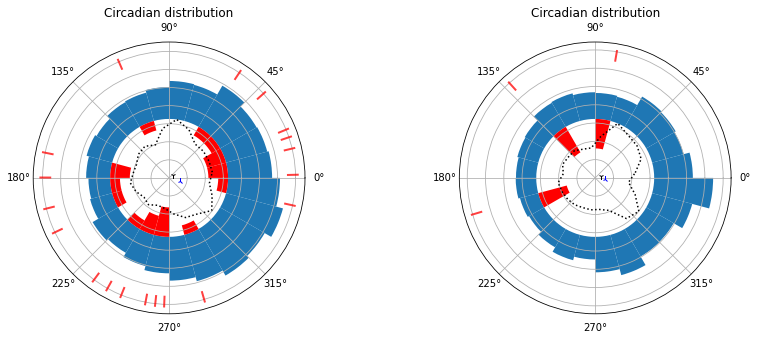




 ./YQ data for Marco/104_YQ_True_dex.pkl GFP


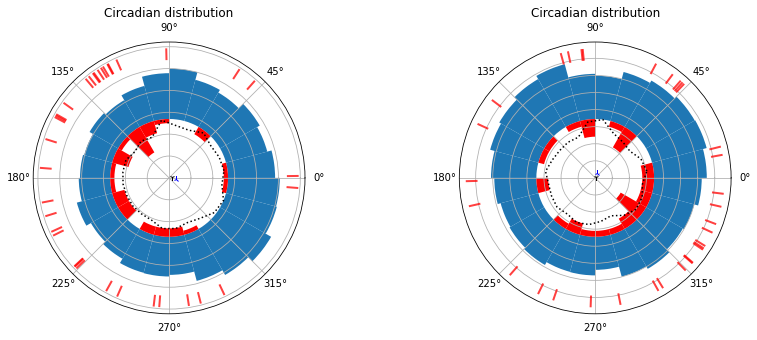




 ./YQ data for Marco/214_YQ_True_dex.pkl GFP


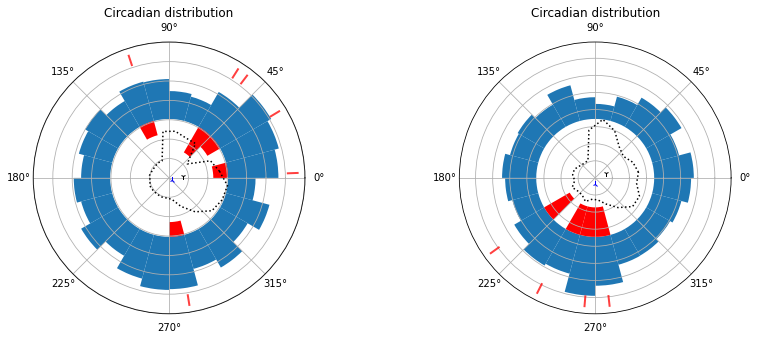




 ./YQ data for Marco/215_YQ_True_dex.pkl GFP
no seizures for polar plot


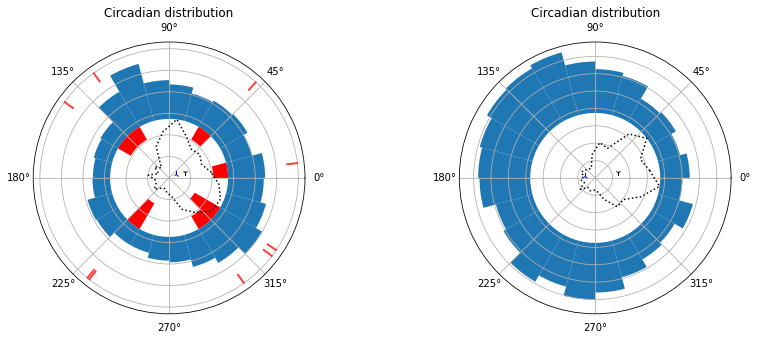




 ./YQ data for Marco/212_YQ_True_dex.pkl GFP


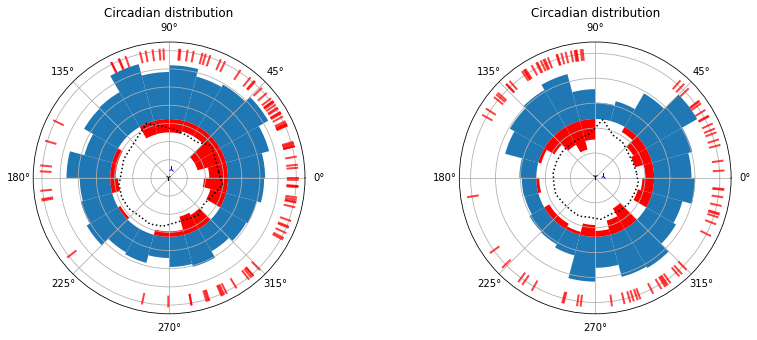




 ./YQ data for Marco/210_YQ_True_dex.pkl GFP


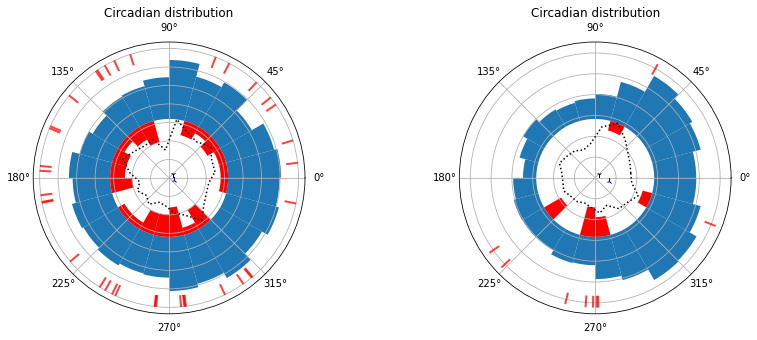




 ./YQ data for Marco/49_YQ_True_dex.pkl KV1.1


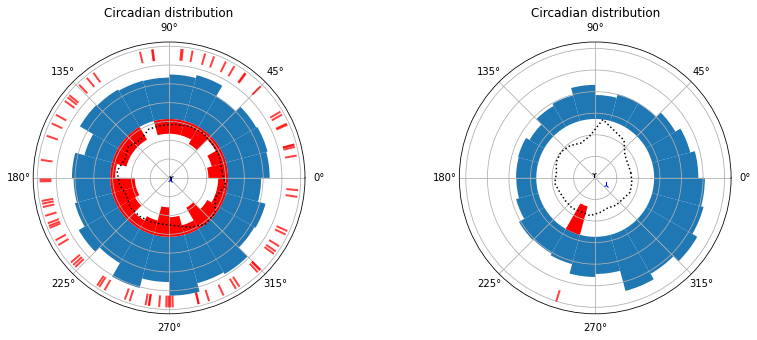




 ./YQ data for Marco/213_YQ_True_dex.pkl KV1.1
no seizures for polar plot


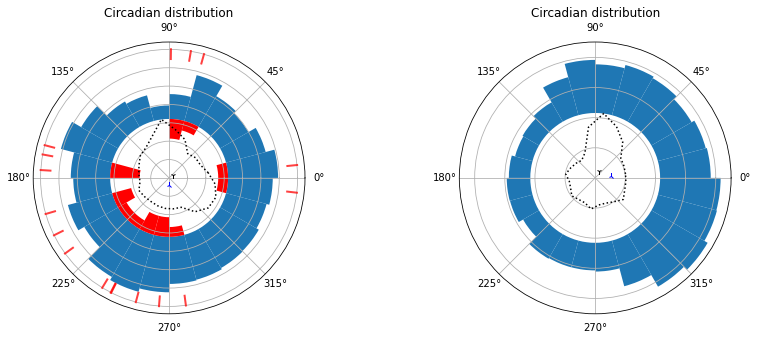




 ./YQ data for Marco/94_YQ_True_dex.pkl KV1.1


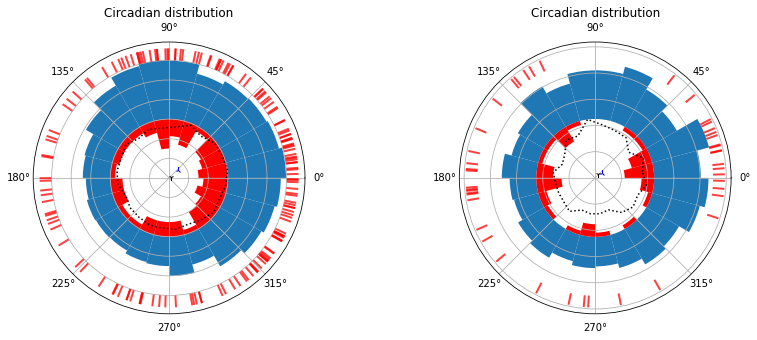




 ./YQ data for Marco/211_YQ_True_dex.pkl KV1.1


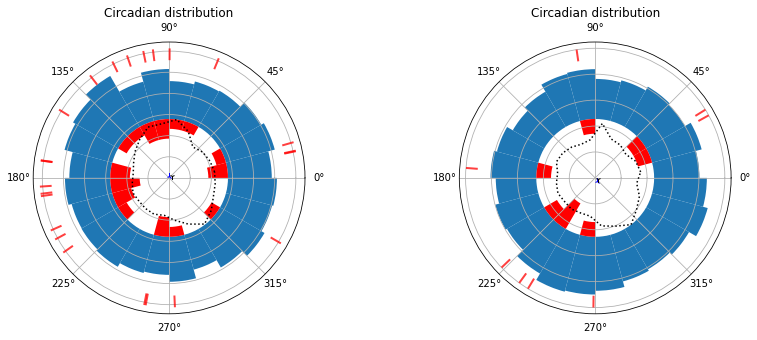




 ./YQ data for Marco/99_YQ_True_dex.pkl KV1.1


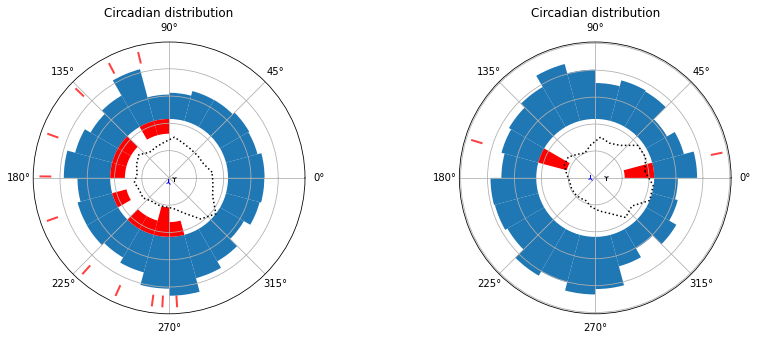




 ./YQ data for Marco/193_YQ_True_dex.pkl KV1.1
no seizures for polar plot


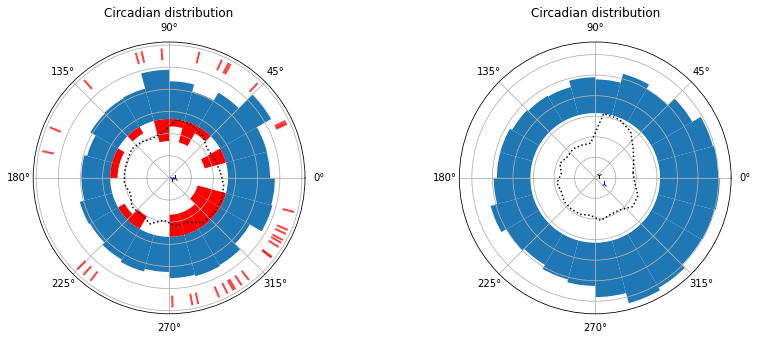




 ./YQ data for Marco/51_YQ_True_dex.pkl KV1.1
no seizures for polar plot


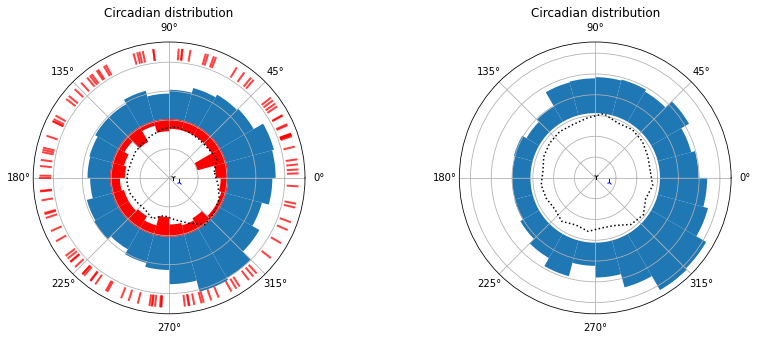




 ./YQ data for Marco/50_YQ_True_dex.pkl Kir2.1
no seizures for polar plot
no seizures for polar plot


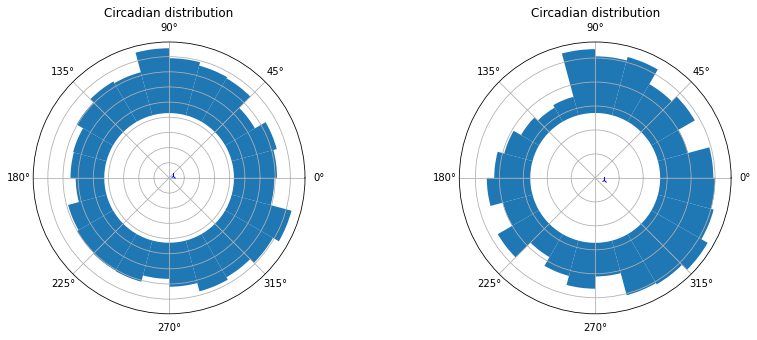




 ./YQ data for Marco/52_YQ_True_dex.pkl Kir2.1
no seizures for polar plot
no seizures for polar plot


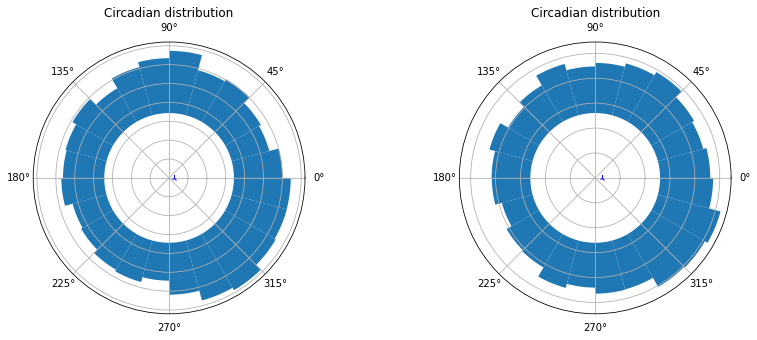




 ./YQ data for Marco/44_YQ_True_dex.pkl Kir2.1
no seizures for polar plot
no seizures for polar plot


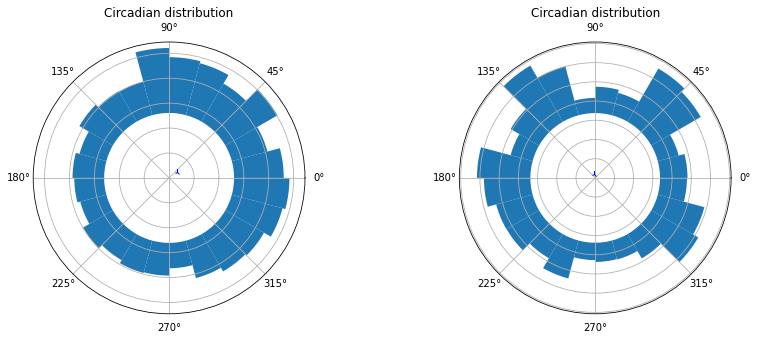




 ./YQ data for Marco/45_YQ_True_dex.pkl Kir2.1
no seizures for polar plot
no seizures for polar plot


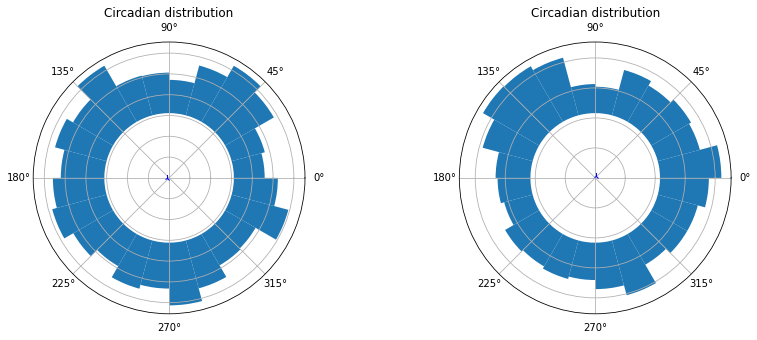

In [220]:
# summarized plots



animal_circadian_spike_cm_dict = {}
animal_circadian_sleep_cm_dict = {}

for i, data in enumerate(all_animals_evt):
#     print('\n\n\n',file_list[i])
    ainmal_id = get_animal.search(file_list[i]).group()[1:-3]
    print('\n\n\n',file_list[i],animal_group_dict[ainmal_id])
    if animal_group_dict[ainmal_id] != 'Kir2.1':
        df = all_feature_list[i]
        df['sleep_proxy'] =  (df["30-50 Hz"]+df["50-70 Hz"]+df["70-120 Hz"])/(df['1-4 Hz'] + df['4-8 Hz'])
        predf = df[df['fname']<=20*3600*24]
        posdf = df[df['fname']>20*3600*24]
    else:
        df = all_feature_list[0]
        df = 0*df
        df['sleep_proxy'] =  (df["30-50 Hz"]+df["50-70 Hz"]+df["70-120 Hz"])/(df['1-4 Hz'] + df['4-8 Hz'])
        predf = df[df['fname']<=20*3600*24]
        posdf = df[df['fname']>20*3600*24]
    
    plt.figure(figsize=(14,5))
    
    baseline = data[data<20*3600*24]
    hourly_baseline,t = np.histogram(baseline/3600,bins=np.arange(0,24*20))
    baseline_files=all_animals_files[i][all_animals_files[i]<20*3600*24]
    baseline_sz=all_seizure_list[i][all_seizure_list[i]<20*3600*24]
    
#     plt.title(file_list[i])
    ax = plt.subplot(1,2,1,polar=True)
    plt.title('Circadian distribution')
    theta = np.linspace(0.0, 2 * np.pi, 24, endpoint=False)+ np.pi/24
    radii,_ = np.histogram((baseline/3600)%24,bins=np.arange(0,25))
    width = (2*np.pi) / 24
    bottom = max(radii)/1
    bars = ax.bar(theta, radii, width=width, bottom=bottom)
    center_of_mass_spike = np.mean(radii*np.exp(1j*theta))/np.std(radii*np.exp(1j*theta))
    ax.plot(np.angle(center_of_mass_spike),np.abs(center_of_mass_spike)*bottom,'b2')
    
    
    if len(baseline_sz)>0:
        radii_sz,_ = np.histogram((baseline_sz/3600)%24,bins=np.arange(0,25))
        bars = ax.bar(theta, -radii_sz/max(radii_sz)*bottom/2, width=width, bottom=bottom,color=[1,0,0])
        ax.vlines(((baseline_sz/3600)/24)*2*np.pi,2*bottom,2.2*bottom,'r',alpha=.75,linewidth=2)
    else:
        print('no seizures for polar plot')
        
    radii = np.array([np.mean(predf[predf['dayhour']==h]['sleep_proxy']) for h in range(24)])
    radii = radii/max(radii)*bottom
    bars = ax.plot(np.concatenate([theta,[theta[0]]]), np.concatenate([radii,[radii[0]]]),'k:')
    center_of_mass_sleep = np.mean(radii*np.exp(1j*theta))/np.std(radii*np.exp(1j*theta))
    ax.plot(np.angle(center_of_mass_sleep),np.abs(center_of_mass_sleep)*bottom,'k1')

    ax.axes.yaxis.set_ticklabels([])
    N = 24*5
    psth_baseline = np.convolve(hourly_baseline,hourly_baseline[::-1])/np.convolve(np.ones(hourly_baseline.shape),np.ones(hourly_baseline.shape))
     
#     # Use custom colors and opacity
#     for r, bar in zip(radii, bars):
#         bar.set_facecolor(plt.cm.jet(r / 10.))
#         bar.set_alpha(0.8)

    post = data[data>20*3600*24]
    hourly_post,t = np.histogram(post/3600,bins=np.arange(30*24,24*52))
    post_files=all_animals_files[i][all_animals_files[i]>20*3600*24]
    post_sz=all_seizure_list[i][all_seizure_list[i]>20*3600*24]
     
    ax = plt.subplot(1,2,2,polar=True)
    plt.title('Circadian distribution')
    theta = np.linspace(0.0, 2 * np.pi, 24, endpoint=False)+ np.pi/24
    width = (2*np.pi) / 24
    radii,_ = np.histogram((post/3600)%24,bins=np.arange(0,25))
    bottom = max(radii)/1
    bars = ax.bar(theta, radii, width=width, bottom=bottom)
    center_of_mass_spike_p = np.mean(radii*np.exp(1j*theta))/np.std(radii*np.exp(1j*theta))
    ax.plot(np.angle(center_of_mass_spike_p),np.abs(center_of_mass_spike_p)*bottom,'b2')
    if len(post_sz)>0:
        radii_sz,_ = np.histogram((post_sz/3600)%24,bins=np.arange(0,25))
        bars = ax.bar(theta, -radii_sz/max(max(radii_sz),1)*bottom/2, width=width, bottom=bottom,color=[1,0,0])
        ax.vlines(((post_sz/3600)/24)*2*np.pi,2*bottom,2.2*bottom,'r',alpha=.75,linewidth=2)
    else:
        print('no seizures for polar plot')
    
    radii = np.array([np.mean(posdf[posdf['dayhour']==h]['sleep_proxy']) for h in range(24)])
    radii = radii/max(radii)*bottom
    bars = ax.plot(np.concatenate([theta,[theta[0]]]), np.concatenate([radii,[radii[0]]]),'k:')
    center_of_mass_sleep_p = np.mean(radii*np.exp(1j*theta))/np.std(radii*np.exp(1j*theta))
    ax.plot(np.angle(center_of_mass_sleep_p),np.abs(center_of_mass_sleep_p)*bottom,'k1')
    
    animal_circadian_spike_cm_dict[ainmal_id] = [center_of_mass_spike, center_of_mass_spike_p]
    animal_circadian_sleep_cm_dict[ainmal_id] = [center_of_mass_sleep, center_of_mass_sleep_p]
    
    ax.axes.yaxis.set_ticklabels([])
    plt.show()

In [213]:
result.pvalue

0.37867498263555754

In [195]:
data1 = np.array((np.real(gfp_sleep_changes),np.imag(gfp_sleep_changes))).T
data2 = np.array((np.real(kv1_sleep_changes),np.imag(kv1_sleep_changes))).T

full_data = np.concatenate((data1,data2))
rss0 = np.sum((full_data-np.mean(full_data,axis=0))**2)

full_data_m = np.concatenate((data1 - np.mean(data1,axis=0), data2 - np.mean(data2,axis=0)))
rss1 = np.sum(full_data_m**2)
F = (rss0-rss1)/rss1*(2*len(full_data)-4)/2 # F-value for model with same mean vs different means
p_value_sleep = (1 - f_dist.cdf(F, 2, (2*len(full_data)-4)))
print('Sleep changes p_value', p_value_sleep)

data1 = np.array((np.real(gfp_spike_changes),np.imag(gfp_spike_changes))).T
data2 = np.array((np.real(kv1_spike_changes),np.imag(kv1_spike_changes))).T

full_data = np.concatenate((data1,data2))
rss0 = np.sum((full_data-np.mean(full_data,axis=0))**2)

full_data_m = np.concatenate((data1 - np.mean(data1,axis=0), data2 - np.mean(data2,axis=0)))
rss1 = np.sum(full_data_m**2)
F = (rss0-rss1)/rss1*(2*len(full_data)-4)/2 # F-value for model with same mean vs different means
p_value_spike = (1 - f_dist.cdf(F, 2, (2*len(full_data)-4)))
print('Spike changes p_value', p_value_spike)


Sleep changes p_value 0.6738441351382838
Spike changes p_value 0.32180472497833534


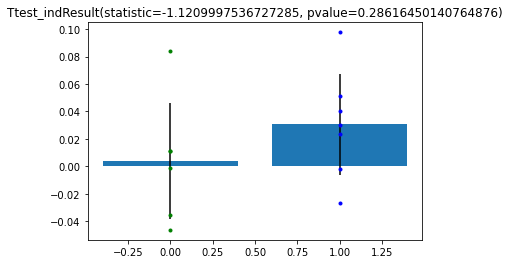

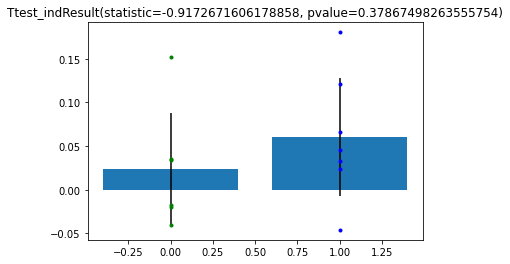